In [1]:
%reset -f

%load_ext autoreload
%autoreload 2
import os
import import_ipynb

from math import exp
import pvlib
import pandas as pd
import numpy as np

from psychrolib import GetHumRatioFromRelHum, SetUnitSystem, SI

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.cm as cm
import matplotlib as mpl

mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['axes.unicode_minus'] = False  # For minus signs to render correctly

from pvlib.tools import sind
from pvlib._deprecation import warn_deprecated
from pvlib.tools import _get_sample_intervals
import scipy
import scipy.constants
import warnings
from scipy.interpolate import interp1d
from tmm import coh_tmm, unpolarized_RT

import functions_module as func 
import func_check as checks
from thermo import Mixture
#print(dir(func))

import nbimporter
# import ET
# %run ET.ipynb
import pyfao56 as fao
import ET_files 
import ET_func


Defining Demo parameters

In [2]:
# General constants
boltz=5.669e-8 #J/(s · m2 · K4) is the Stefan-Boltzmann constant

# MODULE PROPERTIES (Bifacial)
# thermal mass of the PVmodule [J / (m^2 K)] specific heat. Data from [104. PV module specs], [66. KUL demo paper], and [109. demo paper for yieldvsShade].
glass_thickness = 0.0032                  # m, thickness of the glass
total_glass_thickness = 2*glass_thickness # m, total thickness of the glass (front and rear)
tau_glass = 0.8                           # transmittance of the glass
layers_data = [                           # (specific heat capacity [J/kg°C], density [kg/m³], thickness[m], thermal conductivity [W/mK])
    (500, 3000, glass_thickness, 1.8),    # Front Glass
    (2090, 950, 500e-6, 0.35),            # Front Encapsulant (EVA)
    (691, 2400, 100e-9, 32),              # Anti-Reflection Coating (ARC)
    (677, 2330, 225e-6, 148),             # Monocystallyne Silicon Solar Cells + glass      
    (691, 2400, 100e-9, 32),              # Anti-Reflection Coating (ARC)
    (2090, 950, 500e-6, 0.35),            # Back Encapsulant (EVA)
    (500, 3000, glass_thickness, 1.8)     # Rear Glass 
]


# # DEMO KUL PROPERTIES: # #
lat = 50.819                                                                      # deg N
lon = 4.775                                                                       # deg E
altitude = 100                                                                    # m, [66. KUL demo paper]
module_height = 4.2                                                               # m, [66]
module_width = 0.991                                                              # m, [66]   
module_length = 1.649                                                             # m, [66]  
tilt_angle = 12                                                                   # deg, [66]
module_azimuth = 180-60                                                           # deg, 60º orientation of the field rows [66]
wind_height = 10                                                                  # m, Measured wind height [weather station webpage]
row_spacing = 3.3                                                                 # m, [66]
packing_factor = 0.6                                                              # 36/60 (glass-panel), 40% transparency [66]
tree_diameter = 1                                                                 # width tree, m [estimated]
crop_height = 2.4                                                                 # height tree, m [66]
modules_density = (module_width*np.cos(np.radians(tilt_angle))*2)/(row_spacing)   # figure from [66] schematics
crop_density = (tree_diameter)/(row_spacing)                                      # Area crop surface / Area field surface (m2/m2)
field_orientation = 60                                                            # deg, 60º N-W, orientation of the field rows [66]             

mc = func.thermal_mass_PV(layers_data, packing_factor)                            # Module thermal mass/Capacity [J/m2·K]
print('Module Capacity =', mc)

Module Capacity = 11940.18589


IMPORT WEATHER DATA

Check matching dimensions: 8760
8760 8760
8760 8760 8760
8760 8760 8760 8760 8760 12 365


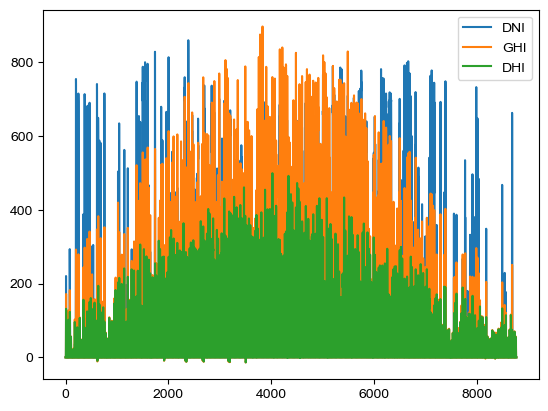

In [3]:
# DEMO WEATHER DATA BOLZANO/KUL
weather_data_L = pd.read_csv('Weather/Laimburg_weather_2023.csv')                   # Laimburg weather data 2023 for Bolzano, Italy
weather_data_U = pd.read_csv('Weather/Ukkel_10min_2024.csv', delimiter=';')         # Ukkel weather data 2024 for KUL, Belgium
weather_data_G = pd.read_csv('Weather/Gembloux_10min_2024.csv', delimiter=';')      # Gembloux weather data 2024 for KUL, Belgium

# Get time index
times = pd.date_range('2024-01-01 00:00:00', freq='h', periods=8784)                # index type instead of series
times = times[~((times.month == 2) & (times.day == 29))]
print('Check matching dimensions:', len(times))
datetime_index_10min = weather_data_U['timestamp']

weather_data_U['timestamp'] = pd.to_datetime(weather_data_U['timestamp'], format='%Y-%m-%d %H:%M:%S')
weather_data_U.set_index('timestamp', inplace=True)
weather_data_G['timestamp'] = pd.to_datetime(weather_data_G['timestamp'], format='%Y-%m-%d %H:%M:%S')
weather_data_G.set_index('timestamp', inplace=True)
weather_data_U['month'] = weather_data_U.index.month
weather_data_U['day'] = weather_data_U.index.day


# Radiation data
AOI_front, solpos = func.AOIfront_calc(tilt_angle, module_azimuth, lat, lon, times)
print(len(AOI_front), len(solpos))
DNI_10min = weather_data_U['sun_int_avg']                                   # DNI (W/m^2)
GHI_10min = weather_data_U['short_wave_from_sky_avg']                       # GHI (W/m^2)

DNI_leap = weather_data_U['sun_int_avg'].resample('1h').mean()              # Adapt for leap year
GHI_leap = weather_data_U['short_wave_from_sky_avg'].resample('1h').mean()  # Adapt for leap year
leap_day_hours = DNI_leap.loc['2024-02-29']

DNI = DNI_leap.drop(index=leap_day_hours.index)
GHI = GHI_leap.drop(index=leap_day_hours.index)
DHI = GHI - DNI*np.cos(np.radians(solpos['apparent_zenith']))               # DHI = GHI - DNI*cos(zenith) [W/m2]
DNI = DNI.values
GHI = GHI.values
DHI = DHI.values

plt.plot(DNI, label='DNI')
plt.plot(GHI, label='GHI')  
plt.plot(DHI, label='DHI')
plt.legend()

print(len(DHI), len(DNI), len(GHI))


# PANDA SERIES Weather conditions dt = 10min
Tair_10min = weather_data_U['temp_dry_shelter_avg']                                     # Air Tº in [ºC]
Tair_K_10min = Tair_10min + 273.15                                                      # Air Tº in [K]
pressure_10min = weather_data_U['pressure']*100                                         # Pressure in [Pa]
RH_10min = weather_data_U['humidity_rel_shelter_avg']/100                               # RH in fraction [-]
precipitation_10min = weather_data_U['precip_quantity']                                 # Precipitation in [mm]

wind_speed_measured_10min = weather_data_G['wind_speed_10m']                            # Wind speed in [m/s]
wind_speed_direction_10min = weather_data_G['wind_direction']                           # Wind speed direction in [deg] clockwise from N, ws direction general wind direction, that's why we use G statio (topology, ~distance, on wind direction)

wind_speed_measured_10min_U = weather_data_U['wind_speed_10m']                          # Wind speed in [m/s]
wind_speed_direction_10min_U = weather_data_U['wind_direction']                         # Wind speed direction in [deg] clockwise from N, ws direction general wind direction, that's why we use G statio (topology, ~distance, on wind direction)


# PANDA SERIES Change to dt = 1hr
Tair_leap = weather_data_U['temp_dry_shelter_avg'].resample('1h').mean()
Tair_K_leap = Tair_leap + 273.15
pressure_leap = (weather_data_U['pressure'] * 100).resample('1h').mean()
RH_leap = (weather_data_U['humidity_rel_shelter_avg'] / 100).resample('1h').mean()
precipitation_leap = weather_data_U['precip_quantity'].resample('1h').sum()

wind_speed_measured_leap = weather_data_G['wind_speed_10m'].resample('1h').mean()                            # Wind speed in [m/s]
wind_speed_direction_leap = weather_data_G['wind_direction'].resample('1h').mean()                           # Wind speed direction in [deg] clockwise from N, ws direction general wind direction, that's why we use G statio (topology, ~distance, on wind direction)
wind_speed_measured_leap_U = weather_data_U['wind_speed_avg_30m'].resample('1h').mean()                      # Wind speed in [m/s]
wind_speed_direction_leap_U = weather_data_U['wind_direction'].resample('1h').mean()                         # Wind speed direction in [deg] clockwise from N, ws direction general wind direction, that's why we use G statio (topology, ~distance, on wind direction)


# PANDA SERIES Remove 29th February (Leap year)
leap_day_hours = Tair_leap.loc['2024-02-29']
Tair = Tair_leap.drop(index=leap_day_hours.index)
Tair_K = Tair_K_leap.drop(index=leap_day_hours.index)
pressure = pressure_leap.drop(index=leap_day_hours.index)        
RH = RH_leap.drop(index=leap_day_hours.index)
precipitation = precipitation_leap.drop(index=leap_day_hours.index)

wind_speed_measured = wind_speed_measured_leap.drop(index=leap_day_hours.index)
wind_speed_direction = wind_speed_direction_leap.drop(index=leap_day_hours.index)
wind_speed_measured_U = wind_speed_measured_leap_U.drop(index=leap_day_hours.index)
wind_speed_direction_U = wind_speed_direction_leap_U.drop(index=leap_day_hours.index)

# to NUMPY ARRAYs:
Tair = Tair.values
Tair_K = Tair_K.values
pressure = pressure.values
RH = RH.values
precipitation = precipitation.values

wind_speed_measured = wind_speed_measured.values
wind_speed_direction = wind_speed_direction.values
wind_speed_measured_U = wind_speed_measured_U.values
wind_speed_direction_U = wind_speed_direction_U.values

precipitation_series = precipitation_leap.drop(index=leap_day_hours.index)
monthly_precipitation = precipitation_series.groupby(precipitation_series.index.month).sum()
precipitation_day = precipitation_series.groupby(precipitation_series.index.date).sum()
monthly_precipitation = monthly_precipitation.values
precipitation_day = precipitation_day.values


print(len(Tair), len(Tair_K), len(pressure), len(RH), len(precipitation), len(monthly_precipitation), len(precipitation_day))


Tnoct = 48 #ºC
inoct_installed = float(Tnoct-3)                 # INOCT rack ground mounted
Tamb = Tair                                      # hourly air temperature [°C],
Tmax_day = np.max(Tamb.reshape(-1, 24), axis=1)  # max Tº of the day
Tmin_day = np.min(Tamb.reshape(-1, 24), axis=1)  # min Tº of the day
RHmax_day = np.max(RH.reshape(-1, 24), axis=1)   # max RH of the day
RHmin_day = np.min(RH.reshape(-1, 24), axis=1)   # min RH of the day
RH_day = np.mean(RH.reshape(-1, 24), axis=1)     # mean RH of the day



Scale Wind speed

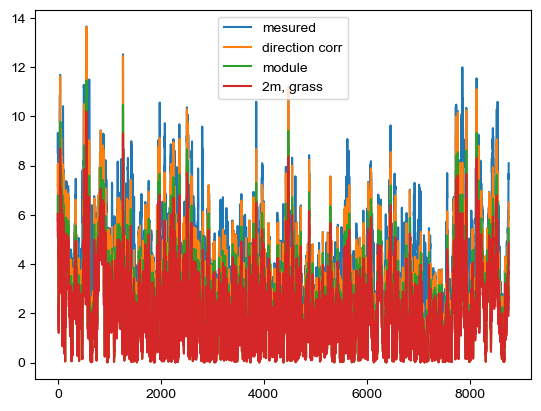

In [4]:
wind_speed, wind_speed_module_day, wind_speed_2m, wind_speed_2m_day, wind_speed_orientation_correction, wind_speed_measured_day = func.wind_speed_calc(wind_speed_measured, wind_speed_direction, module_height, wind_height, field_orientation)

plt.plot(wind_speed_measured, label = 'mesured')
plt.plot(wind_speed_orientation_correction, label = 'direction corr')
plt.plot(wind_speed, label = 'module')
plt.plot(wind_speed_2m, label = '2m, grass')
plt.legend()

IMPORT RAYTRACING RADIATION RESULTS

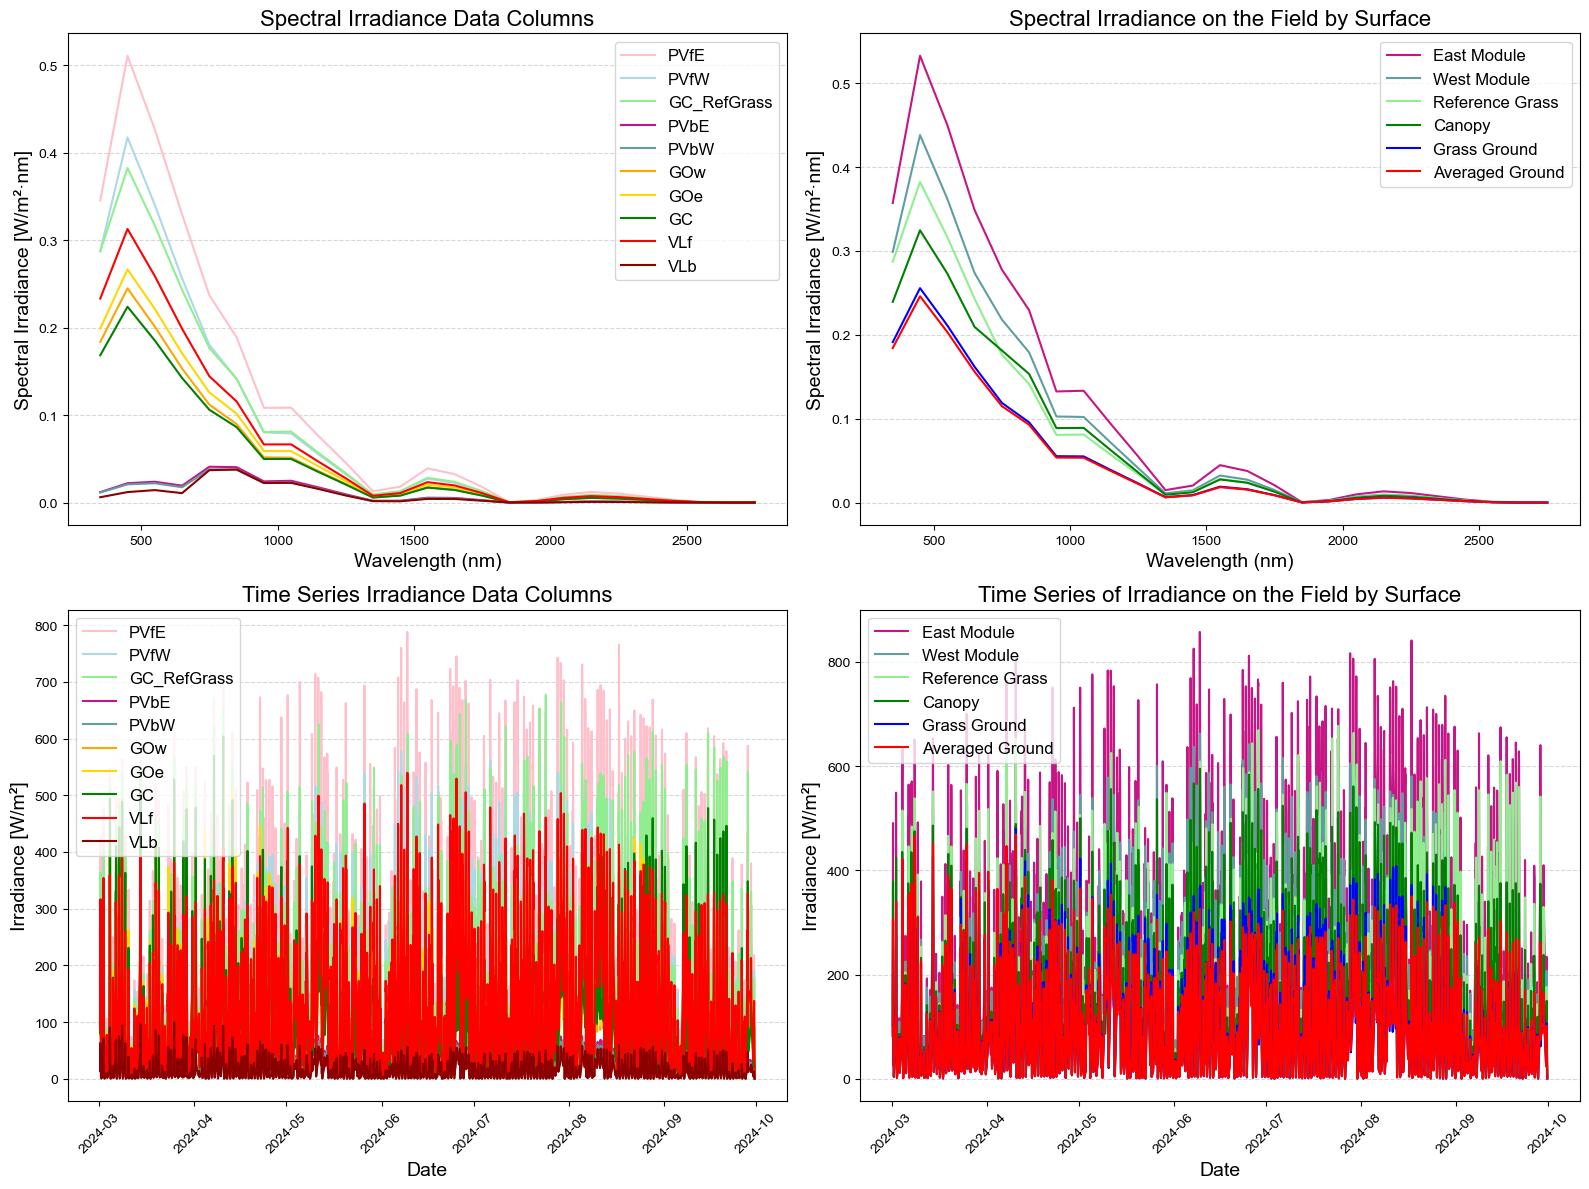

Annual irradiance: 537.6647490826193 kWh/m2
G_gr[W/m2] 124.31482422374384 G_crop[W/m2] 177.30441320901667 G_grass[W/m2] 128.79373228093786 G_mod_W[W/m2] 222.26736216726718 G_mod_E[W/m2] 279.79949698935167


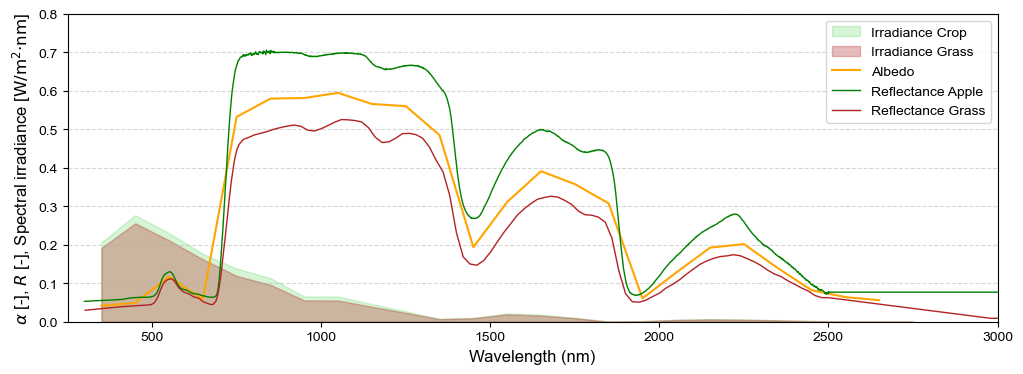

Albedo: 0.2538899615735084


In [5]:
# Load the two datasets of raytracing radiation results in [W/m2] per band width of 100nm (not in [W/m2·nm])
df_300_1200 = pd.read_csv("Weather/Crop_included_300-1200nm.csv")
df_1200_2800 = pd.read_csv("Weather/Crop_included_1200-2800nm.csv")

df_300_1200_excl = pd.read_csv("Weather/Crop_excluded_300-1200nm.csv")
df_1200_2800_excl = pd.read_csv("Weather/Crop_excluded_1200-2800nm.csv")

# Inspect structure of the data (first few columns and rows)
info_300_1200 = {"columns": df_300_1200.columns[:10].tolist(), "num_columns": len(df_300_1200.columns), "num_rows": len(df_300_1200)}
info_1200_2800 = {  "columns": df_1200_2800.columns[:10].tolist(), "num_columns": len(df_1200_2800.columns), "num_rows": len(df_1200_2800)}

# IMPORT SPECTRAL IRRADIANCE AM1.5
spectral_irradiance_data = pd.read_excel('Weather/Spectral_irradiance.xlsx')
wavelength_irradiance = spectral_irradiance_data["Wavelength (nm)"]
Spectral_irradiance_AM15 = spectral_irradiance_data['Global tilt  W/m2/nm'] # W/m2/nm

##############################################  SPECTRAL RADIATION DATA  #######################################################

# Extract for all requested segments
components = ['PVfE', 'PVfW', 'PVbE', 'PVbW', 'GOw', 'GOe', 'GC', 'VLf', 'VLb']
spectral_radiation_df = pd.concat([func.Radiation_extract_spectral_data(comp, df_300_1200, df_1200_2800)/100 for comp in components], axis=1)  #  W·nm/m²
components_excl = ['PVfE', 'PVfW', 'PVbE', 'PVbW', 'GOw', 'GOe', 'GC']
spectral_radiation_df_excl = pd.concat([func.Radiation_extract_spectral_data_excl(comp, df_300_1200_excl, df_1200_2800_excl)/100 for comp in components_excl], axis=1)  #  W·nm/m²
wavelength_irradiance_bands = spectral_radiation_df.index.values  # nm

# Irradiance per nm [W/m2·nm]
spectral_radiation_grass = (spectral_radiation_df['GOe'] + spectral_radiation_df['GOw']) / 2                                                                     # Grass surface irradiance [W/m2·nm] --> Albedo estimation
spectral_radiation_ground = crop_density * spectral_radiation_df['GC'] + (1 - crop_density) * spectral_radiation_grass                                           # Ground surface irradiance [W/m2·nm] --> Tground estimation, irrigation for Ke estimation
spectral_radiation_crop = spectral_radiation_df['VLf'] + spectral_radiation_df['VLb']                                                                            # On leaves --> albedo                       
spectral_radiation_ReferenceGrass = spectral_radiation_df_excl['GC']                                                                                             # Crop surface irradiance [W/m2·nm] --> ET0 estimation
spectral_radiation_module_W = spectral_radiation_df['PVfW'] + spectral_radiation_df['PVbW']                                                                      # West Module surface irradiance [W/m2·nm] --> Tmodule estimation
spectral_radiation_module_E = spectral_radiation_df['PVfE'] + spectral_radiation_df['PVbE']                                                                      # East Module surface irradiance [W/m2·nm] --> Tmodule estimation

##############################################  TIME SERIES RADIATION DATA  #######################################################

# Get the total hourly irradiance for all components
irradiance_w_m2 = pd.DataFrame({comp: func.Radiation_extract_time_series(comp, df_300_1200, df_1200_2800) for comp in components})  #in [W·nm/m²]*1nm = [W/m²]
irradiance_w_m2_excl = pd.DataFrame({comp: func.Radiation_extract_time_series_excl(comp, df_300_1200_excl, df_1200_2800_excl) for comp in components_excl})  #in [W·nm/m²]*1nm = [W/m²]

# Irradiance per hour [W/m2]
poa_grass = (irradiance_w_m2['GOe'] + irradiance_w_m2['GOw']) / 2                            # Grass surface irradiance [W/m2]       --> Albedo estimation
poa_ground = crop_density * irradiance_w_m2['GC'] + (1-crop_density) * poa_grass             # Ground surface irradiance [W/m2]      --> Tground estimation
poa_crop = irradiance_w_m2['VLf'] + irradiance_w_m2['VLb']                                   # Canopy surface irradiance [W/m2]      --> albedo                         
poa_ReferenceGrass = irradiance_w_m2_excl['GC']                                              # Reference Grass Crop irradiance [W/m2]--> ET0 estimation
poa_module_W = irradiance_w_m2['PVfW'] + irradiance_w_m2['PVbW']                             # West Module surface irradiance [W/m2] --> Tmodule estimation  
poa_module_E = irradiance_w_m2['PVfE'] + irradiance_w_m2['PVbE']                             # East Module surface irradiance [W/m2] --> Tmodule estimation

# Align index with weather data:
poa_grass.index = (poa_grass.index + pd.Timedelta(minutes=30)).tz_convert(None)
poa_ground.index = (poa_ground.index + pd.Timedelta(minutes=30)).tz_convert(None)
poa_crop.index = (poa_crop.index + pd.Timedelta(minutes=30)).tz_convert(None)
poa_ReferenceGrass.index = (poa_ReferenceGrass.index + pd.Timedelta(minutes=30)).tz_convert(None)
poa_module_W.index = (poa_module_W.index + pd.Timedelta(minutes=30)).tz_convert(None)
poa_module_E.index = (poa_module_E.index + pd.Timedelta(minutes=30)).tz_convert(None)


##############################################  PLOTTING DATA  #######################################################
fig, axs = plt.subplots(2, 2, figsize=(16, 12))#, dpi=600)
axs = axs.flatten()  # make it a simple list for easier indexing

####################### 1 - Spectral Irradiance Data Columns #######################
axs[0].set_title("Spectral Irradiance Data Columns", fontsize=16)
axs[0].plot(spectral_radiation_df['PVfE'], label='PVfE', color='pink')
axs[0].plot(spectral_radiation_df['PVfW'], label='PVfW', color='lightblue')
axs[0].plot(spectral_radiation_df_excl['GC'], label='GC_RefGrass', color='lightgreen')
axs[0].plot(spectral_radiation_df['PVbE'], label='PVbE', color='#C71585')
axs[0].plot(spectral_radiation_df['PVbW'], label='PVbW', color='#5F9EA0')
axs[0].plot(spectral_radiation_df['GOw'], label='GOw', color='orange')
axs[0].plot(spectral_radiation_df['GOe'], label='GOe', color='#FFD700')
axs[0].plot(spectral_radiation_df['GC'], label='GC', color='green')
axs[0].plot(spectral_radiation_df['VLf'], label='VLf', color='r')
axs[0].plot(spectral_radiation_df['VLb'], label='VLb', color='darkred')
axs[0].grid(True, axis='y', linestyle='--', alpha=0.5)
axs[0].set_xlabel("Wavelength (nm)", fontsize=14)
axs[0].set_ylabel("Spectral Irradiance [W/m²·nm]", fontsize=14)
axs[0].legend(fontsize=12)

####################### 2 - Spectral Irradiance Field #################################
axs[1].set_title("Spectral Irradiance on the Field by Surface", fontsize=16)
axs[1].plot(spectral_radiation_module_E, label='East Module', color='#C71585')
axs[1].plot(spectral_radiation_module_W, label='West Module', color='#5F9EA0')
axs[1].plot(spectral_radiation_ReferenceGrass, label='Reference Grass', color='lightgreen')
axs[1].plot(spectral_radiation_crop, label='Canopy', color='green')
axs[1].plot(spectral_radiation_grass, label='Grass Ground', color='b')
axs[1].plot(spectral_radiation_ground, label='Averaged Ground', color='red')
axs[1].grid(True, axis='y', linestyle='--', alpha=0.5)
axs[1].set_xlabel("Wavelength (nm)", fontsize=14)
axs[1].set_ylabel("Spectral Irradiance [W/m²·nm]", fontsize=14)
axs[1].legend(fontsize=12)

####################### 3 - Time Series Irradiance Data Columns #######################
axs[2].set_title("Time Series Irradiance Data Columns", fontsize=16)
axs[2].plot(irradiance_w_m2['PVfE'], label='PVfE', color='pink')
axs[2].plot(irradiance_w_m2['PVfW'], label='PVfW', color='lightblue')
axs[2].plot(irradiance_w_m2_excl['GC'], label='GC_RefGrass', color='lightgreen')
axs[2].plot(irradiance_w_m2['PVbE'], label='PVbE', color='#C71585')
axs[2].plot(irradiance_w_m2['PVbW'], label='PVbW', color='#5F9EA0')
axs[2].plot(irradiance_w_m2['GOw'], label='GOw', color='orange')
axs[2].plot(irradiance_w_m2['GOe'], label='GOe', color='#FFD700')
axs[2].plot(irradiance_w_m2['GC'], label='GC', color='green')
axs[2].plot(irradiance_w_m2['VLf'], label='VLf', color='r')
axs[2].plot(irradiance_w_m2['VLb'], label='VLb', color='darkred')
axs[2].set_xlabel("Date", fontsize=14)
axs[2].set_ylabel("Irradiance [W/m²]", fontsize=14)
axs[2].legend(fontsize=12)
axs[2].grid(True, axis='y', linestyle='--', alpha=0.5)
axs[2].tick_params(axis='x', rotation=45)

####################### 4 - Time Series of Surface Irradiance in the Field #######################
axs[3].set_title("Time Series of Irradiance on the Field by Surface", fontsize=16)
axs[3].plot(poa_module_E, label='East Module', linewidth=1.5, color='#C71585')
axs[3].plot(poa_module_W, label='West Module', linewidth=1.5, color='#5F9EA0')
axs[3].plot(poa_ReferenceGrass, label='Reference Grass', linewidth=1.5, color='lightgreen')
axs[3].plot(poa_crop, label='Canopy', linewidth=1.5, color='green')
axs[3].plot(poa_grass, label='Grass Ground', linewidth=1.5, color='b')
axs[3].plot(poa_ground, label='Averaged Ground', linewidth=1.5, color='red')
axs[3].set_xlabel("Date", fontsize=14)
axs[3].set_ylabel("Irradiance [W/m²]", fontsize=14)
axs[3].legend(fontsize=12)
axs[3].grid(True, axis='y', linestyle='--', alpha=0.5)
axs[3].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

annual_irradiation = poa_module_W.sum() / 1000              # Annual irradiance [kWh/m2]  only for 1st March - 30th September 2024
print('Annual irradiance:',annual_irradiation,'kWh/m2')     # To check, G_total('ground')=155.03 W/m2 Bolzano, 117 W/m2 for Belgium in average year
print('G_gr[W/m2]', np.mean(poa_ground), 'G_crop[W/m2]', np.mean(poa_crop), 'G_grass[W/m2]', np.mean(poa_grass), 'G_mod_W[W/m2]', np.mean(poa_module_W), 'G_mod_E[W/m2]', np.mean(poa_module_E))


# # CALCULATE: ALBEDO, AOI # #
albedo, albedo_spectral = func.calc_albedo(crop_density, spectral_radiation_crop, spectral_radiation_grass)   # Estimated ALBEDO, an approximation for the transposition-based radiation model
AOI_front, solpos = func.AOIfront_calc(tilt_angle, module_azimuth, lat, lon, times)                           # Angle of incidence [º]

Couple RayTracing and Transposition models

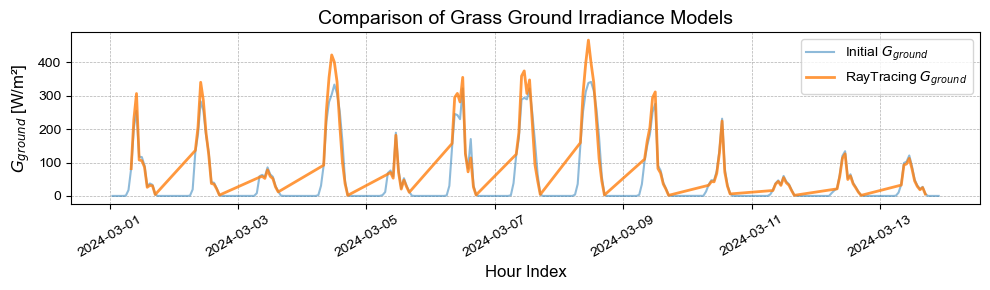

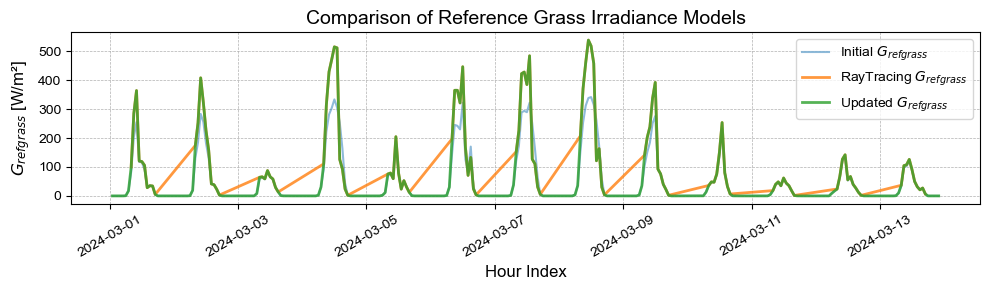

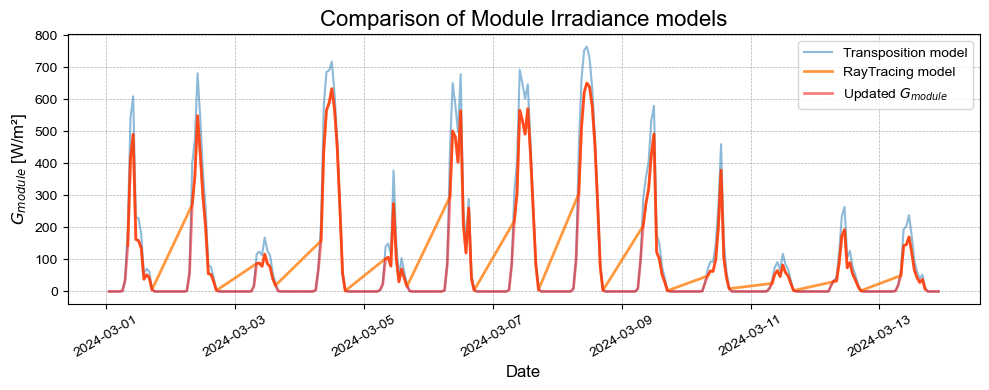

In [6]:
############################################################# POA GROUND IRRADIANCE #############################################################

surface = 'grass'
poa_ground_old, AOI_front, annual_irradiation_old, G_total_old, G_dir_old, G_diff_old, G_refl_old = func.radiation(Tair_K, DNI, DHI, GHI, albedo, tilt_angle, module_azimuth, surface, modules_density, packing_factor, tau_glass, lat, lon, times) # [W/m2], Radiation on the ground (transposition model with horizontal surface) +[W/m2], add shade from the panels to the ground (density+transparency of panels/soil+cells/glass)
poa_ground_old.index = times

poa_ground_updated1 = poa_ground.combine_first(poa_ground_old)                         # Align poa_ground with poa_ground_old if there is data using combine_first:
poa_ground_updated2 = poa_ground_updated1.sort_index()
poa_ground_updated3 = poa_ground_updated2.loc[poa_ground_updated2.index.isin(times)]
poa_ground_updated = poa_ground_updated3.copy()                                        # FINAL UPDATED POA GROUND IRRADIANCE: Averaged Irradiance on the ground (crop, grass) W/m2

# Choose time range to plot results (from 2024-03-01 07:00:00 to 2024-09-30 15:00:00)
low_plot_radiation = '2024-03-01 01:00:00'  # '2024-01-01 07:00:00'
top_plot_radiation = '2024-03-13 22:00:00'  # '2024-12-31 22:00:00'

'PLOT POA GROUND IRRADIANCE'
plt.figure(figsize=(10,3))#, dpi=600)
plt.plot(poa_ground_old[low_plot_radiation:top_plot_radiation], label='Initial $G_{ground}$', alpha=0.5)
plt.plot(poa_ground[low_plot_radiation:top_plot_radiation], label='RayTracing $G_{ground}$', linewidth=2, alpha=0.8)
# plt.plot(poa_ground_updated[low_plot_radiation:top_plot_radiation], label='Updated $G_{ground}$', linewidth=2, alpha=0.8)
plt.legend()
plt.title('Comparison of Grass Ground Irradiance Models', fontsize=14)
plt.xlabel('Hour Index', fontsize=12)
plt.ylabel('$G_{ground}$ [W/m²]', fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

poa_ground = poa_ground_updated.copy()


############################################################# POA REFERENCE GRASS IRRADIANCE #############################################################

surface = 'grass'
poa_refgrass_old, AOI_front, annual_irradiation_old, G_total_old, G_dir_old, G_diff_old, G_refl_old = func.radiation(Tair_K, DNI, DHI, GHI, albedo, tilt_angle, module_azimuth, surface, modules_density, packing_factor, tau_glass, lat, lon, times) # [W/m2], Radiation on the ground (transposition model with horizontal surface) +[W/m2], add shade from the panels to the ground (density+transparency of panels/soil+cells/glass)
poa_refgrass_old.index = times

poa_refgrass_updated1 = poa_ReferenceGrass.combine_first(poa_refgrass_old)                  # Align poa_ground with poa_ground_old if there is data using combine_first
poa_refgrass_updated2 = poa_refgrass_updated1.sort_index()
poa_refgrass_updated3 = poa_refgrass_updated2.loc[poa_refgrass_updated2.index.isin(times)]
poa_refgrass_updated = poa_refgrass_updated3.copy()                                         # #FINAL UPDATED POA GROUND IRRADIANCE: Averaged Irradiance on the reference grass W/m2

'PLOT POA REFERENCE GRASS IRRADIANCE'
plt.figure(figsize=(10,3))#, dpi=600)
plt.plot(poa_refgrass_old[low_plot_radiation:top_plot_radiation], label='Initial $G_{refgrass}$', alpha=0.5)
plt.plot(poa_ReferenceGrass[low_plot_radiation:top_plot_radiation], label='RayTracing $G_{refgrass}$', linewidth=2, alpha=0.8)
plt.plot(poa_refgrass_updated[low_plot_radiation:top_plot_radiation], label='Updated $G_{refgrass}$', linewidth=2, alpha=0.8)
plt.legend()
plt.title('Comparison of Reference Grass Irradiance Models', fontsize=14)
plt.xlabel('Hour Index', fontsize=12)
plt.ylabel('$G_{refgrass}$ [W/m²]', fontsize=12)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


############################################################# POA GLOBAL (PV MODULE) IRRADIANCE #############################################################

surface = 'module'
poa_global_old, AOI_front, annual_irradiation_old, G_total_old, G_dir_old, G_diff_old, G_refl_old = func.radiation(Tair_K, DNI, DHI, GHI, albedo, tilt_angle, module_azimuth, surface, modules_density, packing_factor, tau_glass, lat, lon, times) # [W/m2], Radiation on the ground (transposition model with horizontal surface) +[W/m2], add shade from the panels to the ground (density+transparency of panels/soil+cells/glass)
poa_global_old.index = times

facing = 'E'  # choose facing of the module (for KUL demo, facing is 'E' or 'W'. For Bolzano demo, only one orientation is used, so facing is not relevant, only poa_global directly)
if facing == 'W':
    poa_global = poa_module_W
elif facing == 'E':
    poa_global = poa_module_E
    
poa_global_updated1 = poa_global.combine_first(poa_global_old)                        # Align poa_global with poa_global_old if there is data using combine_first        
poa_global_updated2 = poa_global_updated1.sort_index()
poa_global_updated3 = poa_global_updated2.loc[poa_global_updated2.index.isin(times)]
poa_global_updated = poa_global_updated3.copy()                                       # FINAL UPDATED POA GROUND IRRADIANCE: Irradiance on the bifacial module W/m2

'PLOT POA GLOBAL IRRADIANCE'
plt.figure(figsize=(10, 4))#, dpi=800)
plt.plot(poa_global_old[low_plot_radiation:top_plot_radiation], label='Transposition model', alpha=0.5)
plt.plot(poa_global[low_plot_radiation:top_plot_radiation], label='RayTracing model', linewidth=2, alpha=0.8)
plt.plot(poa_global_updated[low_plot_radiation:top_plot_radiation], label='Updated $G_{module}$', linewidth=2, alpha=0.5, color='red')
plt.legend()
plt.title('Comparison of Module Irradiance models', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('$G_{module}$ [W/m²]', fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(rotation=30, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


CALCULATE MODULE THERMAL/OPTICAL PROPERTIES (CELL & GLASS)

In [7]:
'This cell is to calculate the properties of the PV cell and glass: absorption_cell, emissivity_cell, absorption_glass, emissivity glass --> absorption, emissivity'


########################################  CELL  PROPERTIES CALCULATION   #############################################  
# Instead of absorption_cell = 0.83 [fuentes] find it using SR and spectral irradiance and albedo and find reflectance of the module

wavelengths_nm = np.arange(300, 2800, 1)  # Includes 2800
wavelength_irradiance_bands 
spectral_radiation_module_Wpernm = spectral_radiation_module_W.repeat(100) 
wavelength_irradiance = wavelengths_nm

absorption_cell_spectral, absorption_cell, SR, wavelength_irradiance_mask, R_cell_spectral = func.alpha_cell_calc(wavelength_irradiance, spectral_radiation_module_Wpernm, E_g=1.12)
emissivity_cell = absorption_cell


########################################  GLASS PROPERTIES CALCULATION  ###############################################

# IMPORT GLASS PROPERTIES: From refractiveindex.info Library -> n,k
dfk = pd.read_csv('Optical/k_SodaLime_IR.txt', sep=r'\s+', engine='python')
k_glass = dfk["k"].mean()                                                          #  light is absorbed within the material (reduction of light intensity)
k_glass_spectral = dfk["k"]
wl_k = dfk["wl"]                                                                   # wavelength [10^-6 m]

dfn = pd.read_csv('Optical/n_SodaLime_IR.txt', sep=r'\s+', engine='python')
n_glass = dfn["n"].mean()                                                          # how light refracts entering the material (reduction of light speed)
n_glass_spectral = dfn["n"]
wl_n = dfn["wl"] 
print(f'Glass optical properties: n = {n_glass:.2f}, k = {k_glass:.2f}')
wl,n_glass_spectral,k_glass_spectral = func.match_spectral_resolution(wl_n, n_glass_spectral, wl_k, k_glass_spectral, wl_common=None)
wavelength_m = wl * 1e-6                                                           # wavelength [m]

# Calculate R(t,λ), T(t,λ), α(t,λ): 
alpha_glass_2D, T_glass_2D, R_glass_2D = func.alpha_glass_spectral_calc_dynamic(n_glass_spectral, k_glass_spectral, total_glass_thickness, wl, AOI_front)   # 2D: (8760, Nλ) calculation of the glass properties

# Time averaged: R(λ), T(λ), α(λ) 
alpha_glass_spectral = np.mean(alpha_glass_2D, axis=0)  # shape (Nλ,) 
R_glass_spectral = np.mean(R_glass_2D, axis=0)
T_glass_spectral = np.mean(T_glass_2D, axis=0)

# Spectral average: R, T, α
wl_avg, G_total_spectral_avg, R_glass_spectral_upd = func.match_spectral_resolution(wavelength_irradiance, spectral_radiation_module_Wpernm, wl, R_glass_spectral, wl_common=None)
R_glass_avg = np.trapz(R_glass_spectral * G_total_spectral_avg, wl_avg) / np.trapz(G_total_spectral_avg, wl_avg)                                            # average reflectance of the glass weighted on the spectrum of the irradiance
alpha_glass_avg = np.trapz(alpha_glass_spectral * G_total_spectral_avg, wl_avg) / np.trapz(G_total_spectral_avg, wl_avg)                                    # average absorptance of the glass weighted on the spectrum of the irradiance
T_glass_avg = np.trapz(T_glass_spectral * G_total_spectral_avg, wl_avg) / np.trapz(G_total_spectral_avg, wl_avg)                                            # average transmittance of the glass weighted on the spectrum of the irradiance

absorption_glass = alpha_glass_avg

print(f'T_glass = {T_glass_avg:.2f}, R_glass = {R_glass_avg:.2f}, absorption glass = {absorption_glass:.2f}, absorption cell = {absorption_cell:.2f}')


########################################  INTEGRATE PROPERTIES  ###############################################
wl_interp = np.linspace(0.3, 100, 500)  # microns
wavelength_m = wl_interp * 1e-6

emissivity, emissivity_glass, emissivity_cell = func.emissivity(alpha_glass_spectral, wl, absorption_cell_spectral[:2000], wavelength_irradiance_mask[:2000], packing_factor, Tm=40+273.15) # [BookB, 33.book, 69-72] # emissivity of the PV module, INPUT Refractive index and extinction coefficient (n, k) for the glass
print(f'Emissivity: {emissivity:.2f}, Emissivity glass: {emissivity_glass:.2f}, Emissivity cell: {emissivity_cell:.2f}')

absorption = func.absorption_avg(absorption_glass, absorption_cell, packing_factor)
print(f'Absorption: {absorption:.2f}, Absorption glass: {absorption_glass:.2f}, Absorption cell: {absorption_cell:.2f}')

poa_global_absorbed = poa_global_updated * absorption
poa_global_absorbed = poa_global_absorbed.values
print(f'Annual front irradiance [kWh/m2] = {annual_irradiation:.2f}, G_heat_absorbed [W/m2]= {np.mean(poa_global_absorbed):.2f}, G_tot_module_avg [W/m2]= {np.mean(poa_global_updated):.2f}')


Energy to heat on cell [W/m²]: 161.52
Glass optical properties: n = 1.53, k = 0.35
T_glass = 0.95, R_glass = 0.00, absorption glass = 0.05, absorption cell = 0.73
Emissivity: 0.57, Emissivity glass: 0.15, Emissivity cell: 0.85
Absorption: 0.45, Absorption glass: 0.05, Absorption cell: 0.73
Annual front irradiance [kWh/m2] = 537.66, G_heat_absorbed [W/m2]= 46.58, G_tot_module_avg [W/m2]= 102.44


INTERPOLATE AMBIENT AIR PROPERTIES and Flow regime

In [8]:
# Air properties
thermal_conductivity, diffusivity, kinematic_viscosity, density, tsky_array, Nu_forced, hconv_top, h_forced_top, h_free_top, Re, Cp, dew_point = (np.zeros(len(wind_speed)) for _ in range(12)) # initial parameters array with zeros.
xlen = func.Dh(module_width, module_length)

for i in range(len(wind_speed)):
    air_prop = func.calc_air_properties(float(Tair_K[i]), float(RH[i]), float(pressure[i]))    # Calculate air properties, function interpolates ambient param. from coolprop anf thermo library, it takes 2-10min.
    (dynamic_viscosity, density[i], kinematic_viscosity[i], Cp[i], thermal_conductivity[i], diffusivity[i], dew_point[i]) = air_prop
    
Re = xlen * wind_speed / kinematic_viscosity                                                   # Reynolds
Pr = kinematic_viscosity / diffusivity                                                         # Prandtl    
Pe = Re*Pr                                                                                     # Peclet
Re_tr = 5e05
flow_regime = np.where(Re < Re_tr, 'laminar', np.where((Re >= Re_tr) & (Re < 1e8), 'transitional', 'turbulent'))
unique, counts = np.unique(flow_regime, return_counts=True)                                    # Convert to percentage
percentages = {regime: (count / len(flow_regime)) * 100 for regime, count in zip(unique, counts)}
print("Flow Regime Percentages:")
for regime, value in percentages.items():
    print(f"  {regime.capitalize()}: {value:.2f}%")

dew_point_day = np.mean(dew_point.reshape(-1, 24), axis=1) - 273.15                            # mean dew point Tº of the day ºC
density_air = density                                                                          # kg/m3
Cp_air_MJ = Cp/10**6                                                                           # specific heat at constant pressure [MJ kg-1 °C-1] ~1.013*10-3  = [J kg-1 K-1]*10^-6

Flow Regime Percentages:
  Laminar: 95.97%
  Transitional: 4.03%


Obtain IRRIGATION.TXT

In [9]:
################################################### CROPWAT IRRIGATION INPUTS ###############################################################
# Climate Input for CROPWAT file
ET0, ET0_day, ET0_FAO_day, ET0_FAO_h, q_ET0_Wm2 = ET_func.ET0_calc(wind_speed_2m, wind_speed_2m_day, Tair, dew_point, RH, pressure, poa_refgrass_updated, density, Cp)  # ET0[mm/day]_h   

dates = pd.date_range(start="2024-01-01", end="2024-12-30", freq="d")
months = dates.month

Rn = poa_refgrass_updated * 0.0036                      # net radiation at the grass surface [MJ m-2 hour-1] = poa_ground[W/m2] * [1W=1J/s] * [3600s/1h] * [10^-6 MJ/J] 
Rn_day = np.sum(Rn.values.reshape(-1, 24), axis=1)      # [MJ m-2 day-1]  .values = from pandas to array type, .reshape = Each row represents a day -> Sum along the hours (columns) for each day
ESH_day = Rn_day/(0.0036*1000)                          # hrs/day = Wh/m2  /  W/m2     [MW s-1 m-2 day-1]/[1kW m-2]...
daily_data = pd.DataFrame({
    'month': months,
    'Tmin_day': Tmin_day,
    'Tmax_day': Tmax_day,
    'RH_day': RH_day,
    'wind_speed_2m_day': wind_speed_2m_day*(3600*24/1000),  # km/day = m/s * [1km/1000m] * [3600*24s/1day]
    'ESH_day': ESH_day,
    'Rad': Rn_day,  # [MJ m-2 day-1]
    'ET0_day': ET0_day,
    'Precipitation_day': precipitation_day,  # [mm]
})
monthly_averages = daily_data.groupby('month').mean()
# print('P_month:', monthly_precipitation) #, 'P_day:', precipitation_day)
# print(monthly_averages)

' !!! Read: !!! Fill in the monthly values in Cropwat... RUN CROPWAT.... get file Irrigation.TXT (Crop irrigation schedule < Daily soil moisture balance < print < ASCII file (no commas separation)) used for ET_files.create_irrigation_file()'

' !!! Read: !!! Fill in the monthly values in Cropwat... RUN CROPWAT.... get file Irrigation.TXT (Crop irrigation schedule < Daily soil moisture balance < print < ASCII file (no commas separation)) used for ET_files.create_irrigation_file()'

EVAPOTRANSPIRATION

In [10]:
################################################### EVAPOTRANSPIRATION ###############################################################

# REFERENCE ET:
ET0, ET0_day, ET0_FAO_day, ET0_FAO_h, q_ET0_Wm2 = ET_func.ET0_calc(
    wind_speed_2m, wind_speed_2m_day, Tair, dew_point, RH, pressure, poa_refgrass_updated, density, Cp
)
print(f"mean values: ET0 = {np.mean(ET0):.2f}, ET0_FAO = {np.mean(ET0_FAO_h):.2f}, q_ET0_Wm2 = {np.mean(q_ET0_Wm2):.2f}")

# Growth Stages for APPLE/PEAR [days]:
Lini = 20
Ldev = 70
Lmid = 90
Llate = 30
Start_growth = 90

# TRANSPIRATION CROP PARAMETERS:
Kcb_table, Kcb_fluct, Kcb = ET_func.Kcb_calc(
    wind_speed_2m_day, RHmin_day * 100, h=crop_height, Lini=Lini, Ldev=Ldev, Lmid=Lmid, Llate=Llate, Start_growth=Start_growth,
    Kcb_nul=0.45, Kcb_ini=0.50, Kcb_mid=0.90, Kcb_end=0.7)

net_irr = ET_files.create_irrigation_file()

# EVAPORATION CROP PARAMETERS:
Ke, Ke_h, Kcb_h, ETc_dual_h, ETc_dual_day, Kr, fc, De_day, q_ETc_dual_day_Wm2, q_ETc_dual_h_Wm2 = ET_func.Ke_ET_calc(
    ET0, ET0_day, Kcb, wind_speed_2m_day, RHmin_day * 100, net_irr, precipitation_day,
    Kc_min=0.15, fw=1, TEW=1000 * (0.27 - 0.07) * 0.1, REW=6, h=crop_height)

print(f"mean values: Ke = {np.mean(Ke):.2f}, Kcb = {np.mean(Kcb):.2f}, Kc = {np.mean(Kcb + Ke):.2f}, ET_dual = {np.mean(ETc_dual_h):.2f}, q_ETc_dual = {np.mean(q_ETc_dual_h_Wm2):.2f}")

# Optional input to Cropwat:
p = 0.5 + 0.04 * (5 - np.mean(ETc_dual_day[Start_growth + Lini + Ldev + Lmid : Start_growth + Lini + Ldev + Lmid + Llate]))
Kc = Kcb + Ke
mean_Kc = np.mean(Kc[Start_growth : Start_growth + Lini])  

# ET RESULTS:
days = pd.date_range(start='2023-01-01', periods=len(ETc_dual_day), freq='D')
ETc_series = pd.Series(ETc_dual_day, index=days)
ETc_dual_month = ETc_series.groupby(ETc_series.index.month).sum()
ETc_dual_month_mean = ETc_series.groupby(ETc_series.index.month).mean()

print(f"Annual avg. ET [W/m2] = {np.mean(q_ETc_dual_h_Wm2):.2f}")


mean values: ET0 = 1.58, ET0_FAO = 1.57, q_ET0_Wm2 = 44.93
mean values: Ke = 0.48, Kcb = 0.63, Kc = 1.12, ET_dual = 1.79, q_ETc_dual = 50.70
Annual avg. ET [W/m2] = 50.70


Artificially induced cases (Only run for sensitivity analysis)

In [11]:
# ################################################### EVAPOTRANSPIRATION ###############################################################

# wind_speed_induced = 0.4 # Induced wind speed factor (e.g., 30% of the wind speed at 2m height)

# # GRASS:
# ET0, ET0_day, ET0_FAO_day, ET0_FAO_h, q_ET0_Wm2 = ET_func.ET0_calc(wind_speed_induced*wind_speed_2m/wind_speed_2m, wind_speed_induced*wind_speed_2m_day/wind_speed_2m_day, Tair, dew_point, RH, pressure, poa_refgrass_updated, density, Cp)  # ET0[mm/day]_h   
# print("mean values: ET0=", np.mean(ET0), "ET0_FAO=", np.mean(ET0_FAO_h), "q_ET0_Wm2=", np.mean(q_ET0_Wm2))
# # FOR APPLE/PEAR:
# Lini=20
# Ldev=70
# Lmid=90
# Llate=30
# Start_growth=90
# Kcb_table, Kcb_fluct, Kcb = ET_func.Kcb_calc(wind_speed_induced*wind_speed_2m_day/wind_speed_2m_day, RHmin_day*100, h = crop_height, Lini=20, Ldev=70, Lmid=90, Llate=30, Start_growth=90,   # Growth stage lengths (days)  FAO[26, table 11]
#                                              Kcb_nul=0.45, Kcb_ini=0.50, Kcb_mid=0.90, Kcb_end=0.7)                                                     #  basal crop coefficient (Kcb) values for each stage FAO[26, table 17]
# net_irr = ET_files.create_irrigation_file()
# Ke, Ke_h, Kcb_h, ETc_dual_h, ETc_dual_day, Kr, fc, De_day, q_ETc_dual_day_Wm2, q_ETc_dual_h_Wm2 = ET_func.Ke_ET_calc(ET0, ET0_day, Kcb, wind_speed_induced*wind_speed_2m_day/wind_speed_2m_day, RHmin_day*100, net_irr, precipitation_day, 
#                                                                   Kc_min = 0.15, fw = 1, TEW = 1000*(0.27-0.07)*0.1 , REW = 6, h = crop_height) # REW/TEW depend on type of soil (Sandy Loam) [table 19], fw (precipitation + sprinkler irrigation) [table 20]
# print("mean values: Ke=", np.mean(Ke), ", Kcb=", np.mean(Kcb), ", Kc=", np.mean(Kcb+Ke),", ET_dual=",np.mean(ETc_dual_h), ", q_ETc_dual=",np.mean(q_ETc_dual_h_Wm2))

# #input to cropwat:
# p = 0.5 + 0.04*(5-np.mean(ETc_dual_day[Start_growth+Lini+Ldev+Lmid:Start_growth+Lini+Ldev+Lmid+Llate])) # Depletion fraction
# Kc = Kcb+Ke
# np.mean(Kc[Start_growth:Start_growth+Lini])

# # ET RESULTS:
# days = pd.date_range(start='2023-01-01', periods=len(ETc_dual_day), freq='D')
# ETc_series = pd.Series(ETc_dual_day, index=days)
# ETc_dual_month = ETc_series.groupby(ETc_series.index.month).sum() # mm/month

# # ETc_dual_month.index = pd.to_datetime(ETc_dual_month.index, format='%m').strftime('%B')
# print(np.round(ETc_dual_month,2))

# # plt.plot(Kcb)
# # plt.plot(Kcb_fluct)

# print('Kcb:', np.mean(Kcb[Start_growth+Lini+Ldev:Start_growth+Lini+Ldev+Lmid]), 'Ke:', np.mean(Ke[Start_growth+Lini+Ldev:Start_growth+Lini+Ldev+Lmid]),'Kc:', np.mean(Kc[Start_growth:Start_growth+Lini+Ldev+Lmid+Llate]))


ET PLOTS (Only to check ET results)

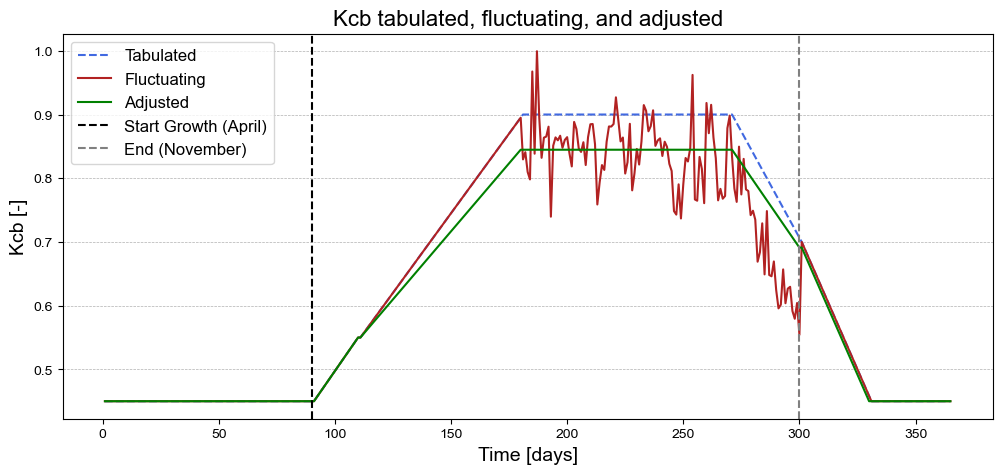

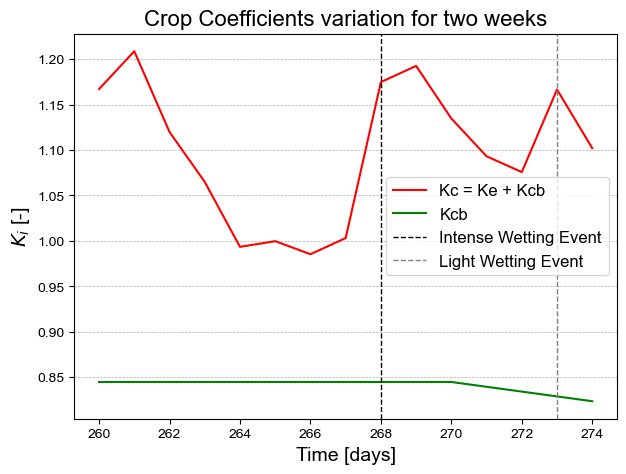

C:\Users\Marta\AppData\Local\Temp\ipykernel_18392\345600671.py:53: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start="2024-01-01", end="2024-12-31", freq='M'),
C:\Users\Marta\AppData\Local\Temp\ipykernel_18392\345600671.py:54: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  labels=[d.strftime('%b') for d in pd.date_range(start="2024-01-01", end="2024-12-31", freq='M')])


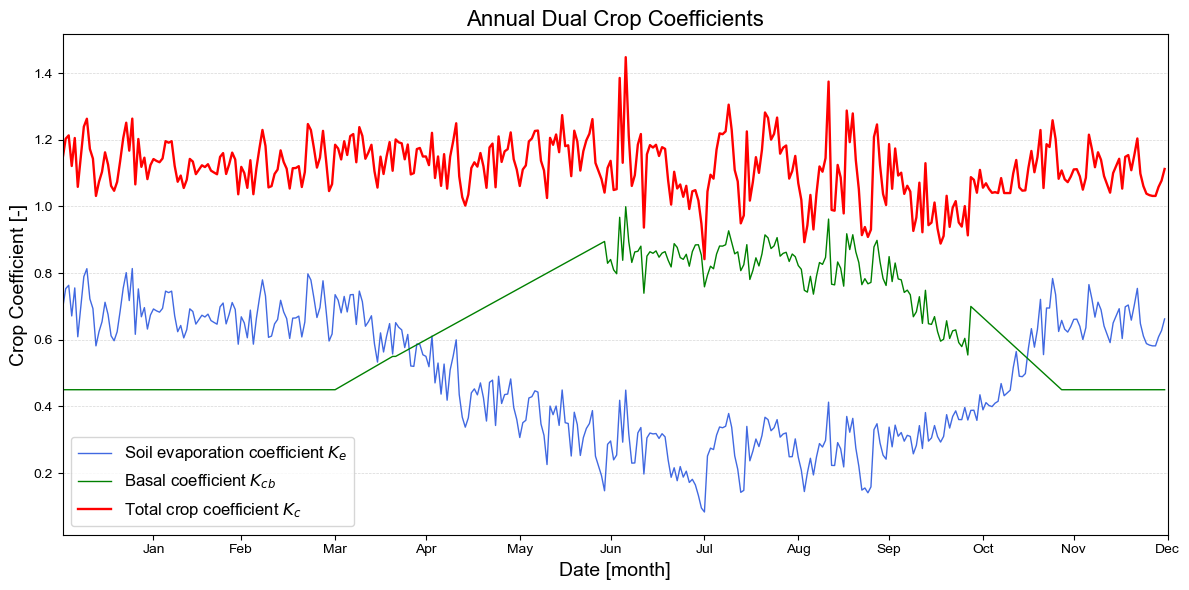

<Figure size 640x480 with 0 Axes>

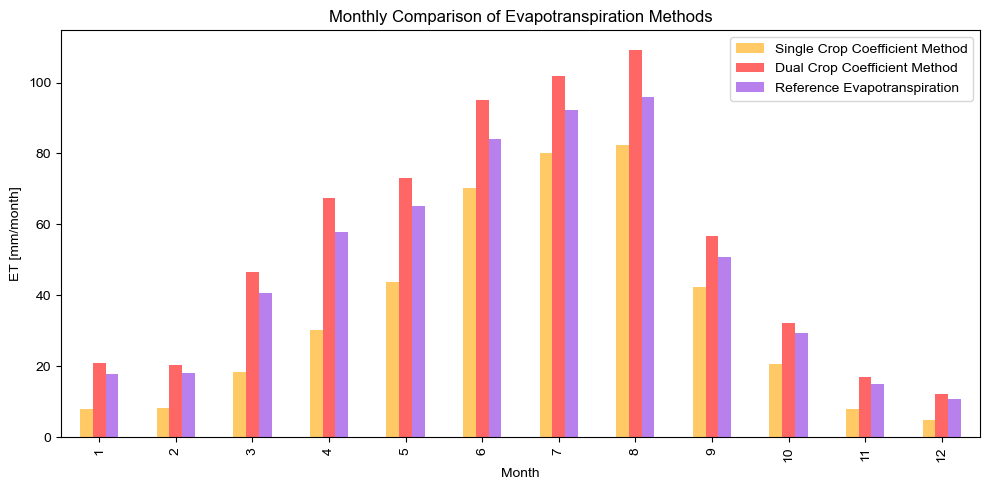

C:\Users\Marta\AppData\Local\Temp\ipykernel_18392\345600671.py:102: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.xticks(pd.date_range(start="2024-01-01", end="2024-12-31", freq='M'),
C:\Users\Marta\AppData\Local\Temp\ipykernel_18392\345600671.py:103: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  labels=[d.strftime('%b') for d in pd.date_range(start="2024-01-01", end="2024-12-31", freq='M')], fontsize=13)


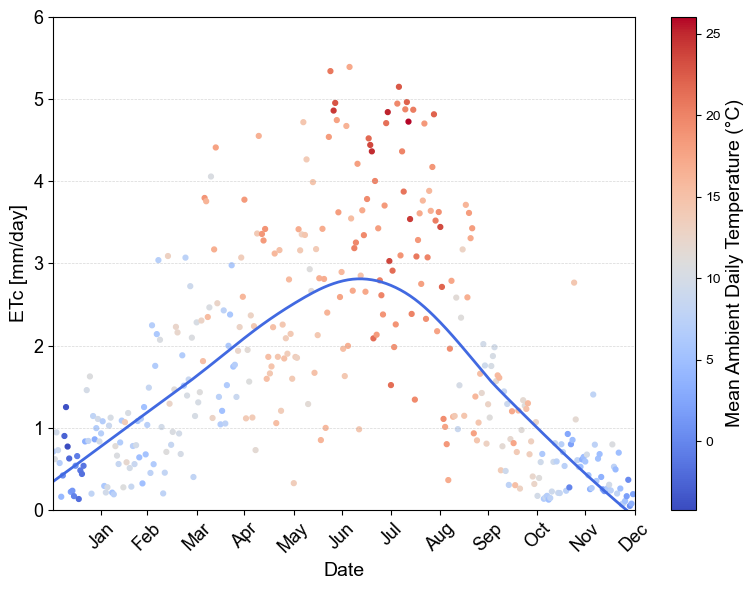

<Figure size 640x480 with 0 Axes>

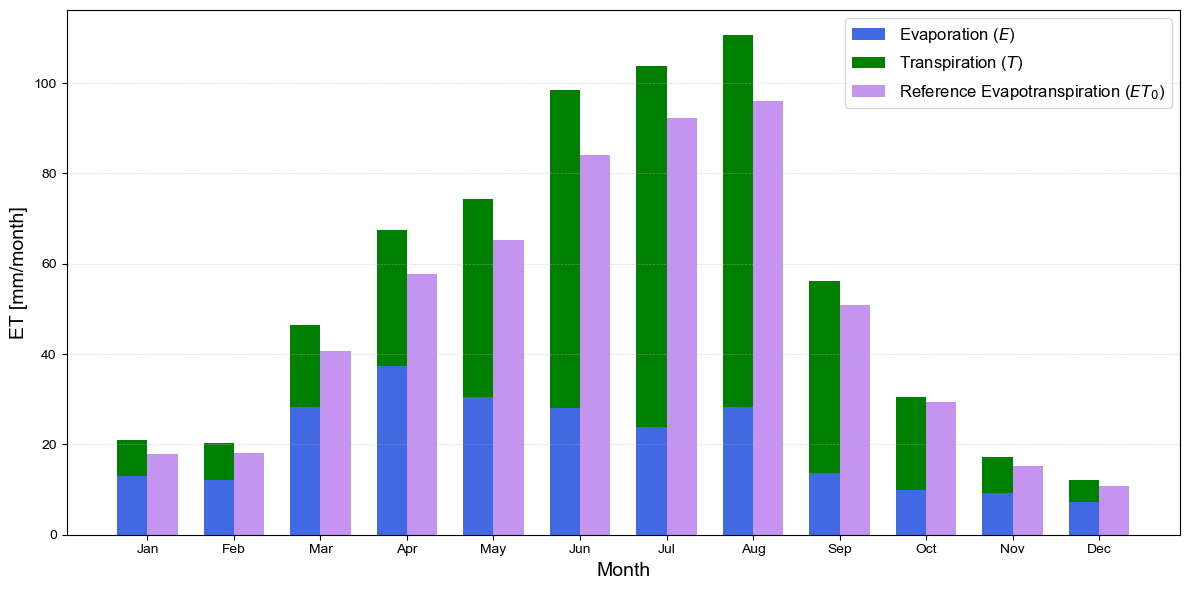

In [12]:
" Kcb, Kcb fluctuations and Kcb_table with transitions"
plt.figure(figsize=(12, 5))
plt.plot(np.arange(1, 366), Kcb_table, label="Tabulated", color="royalblue", linestyle="dashed")
plt.plot(np.arange(1, 366), Kcb_fluct, label="Fluctuating", color="firebrick")
plt.plot(np.arange(1, 366), Kcb, label="Adjusted", color="g")
plt.xlabel("Time [days]", fontsize=14)
plt.ylabel("Kcb [-]", fontsize=14)
plt.title("Kcb tabulated, fluctuating, and adjusted", fontsize=16)
plt.axvline(Start_growth, linestyle="--", color="black", label="Start Growth (April)")
plt.axvline(Start_growth + (Lini + Ldev + Lmid + Llate), linestyle="--", color="gray", label="End (November)")
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

"Homog.Irrigation profile"
# plt.plot(net_irr)  # mm/day

"Kc dual: Ke, Kcb"
low_precip = 260
top_precip = 275
plt.figure(figsize=(7, 5))
plt.plot(np.arange(low_precip, top_precip), Ke[low_precip:top_precip]+Kcb[low_precip:top_precip], label="Kc = Ke + Kcb", color="r")  # 26h april irrigation
plt.plot(np.arange(low_precip, top_precip), Kcb[low_precip:top_precip], label="Kcb", color="g")
# plt.plot(np.arange(0,top_precip-low_precip), Ke[low_precip:top_precip]*ET0_day[low_precip:top_precip], label = 'E')
# plt.plot(precipitation_day[low_precip:top_precip], label="Rain")
# plt.plot(net_irr[low_precip:top_precip], label="Irrigation")
# plt.plot(wind_speed_2m_day[low_precip:top_precip], label="wind")
# plt.axvline(4, linestyle="--", color="black", label="Rain")
plt.axvline(low_precip+8, linestyle="--", color="black",  linewidth=1, label="Intense Wetting Event")
# plt.axvline(10, linestyle="--", color="black")
plt.axvline(low_precip+13, linestyle="--", color="gray",  linewidth=1, label="Light Wetting Event")
plt.xlabel("Time [days]", fontsize=14)
plt.ylabel("$K_i$ [-]", fontsize=14)
plt.title("Crop Coefficients variation for two weeks", fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, axis='y', linestyle='--', linewidth=0.5)
plt.show()

"Annual Kc, Ke, Kcb"
dates = pd.date_range(start='2024-01-01', periods=len(ETc_dual_day), freq='D')
plt.figure(figsize=(12, 6))
# Plot Ke (evaporation)
plt.plot(dates, Ke, color='royalblue', linestyle='-', linewidth=1, label="Soil evaporation coefficient $K_e$")
plt.plot(dates, Kcb_fluct, color='green', linestyle='-', linewidth=1, label="Basal coefficient $K_{cb}$")
plt.plot(dates, Kcb_fluct + Ke, color='r', linestyle='-', linewidth=1.7, label="Total crop coefficient $K_c$")
# Format the x-axis
plt.xlabel("Date [month]", fontsize=14)
plt.ylabel("Crop Coefficient [-]", fontsize=14)
plt.title("Annual Dual Crop Coefficients", fontsize=16)
plt.legend(loc="best", frameon=True, fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
# Improve date formatting
plt.xticks(pd.date_range(start="2024-01-01", end="2024-12-31", freq='M'),
           labels=[d.strftime('%b') for d in pd.date_range(start="2024-01-01", end="2024-12-31", freq='M')])
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2024-12-31"))
plt.tight_layout()
plt.show()


"Monthly Comparison of Evapotranspiration Methods"
plt.figure()
days_array = np.arange(1, 366)
Kc_tab_sing_day, Kc_sing_day = ET_func.Kc_calc(wind_speed_2m_day, RHmin_day*100, h = crop_height, Lini=20, Ldev=70, Lmid=90, Llate=30, Start_growth=90, Kc_nul=0.45, Kc_ini=0.5, Kc_mid=0.9, Kc_end=0.7)
ETc_sing_day = ET0_day * Kc_sing_day  # [mm/day] per day
df = pd.DataFrame({
    'day': days_array,
    'ET_single': ETc_sing_day,
    'ET_dual': ETc_dual_day,
    'ET_ref': ET0_day
})
df['month'] = pd.to_datetime(df['day'], unit='D', origin='2024-01-01').dt.month  # Convert 'day' to datetime and extract month
monthly_sum = df.groupby('month')[['ET_single', 'ET_dual', 'ET_ref']].sum()      # Group by month and sum ET values only (ignore 'day' column here)
ax = monthly_sum.plot(kind='bar', figsize=(10, 5), color=['orange', 'red', 'blueviolet'], alpha=0.6)
plt.title('Monthly Comparison of Evapotranspiration Methods')
plt.ylabel('ET [mm/month]')
plt.xlabel('Month')
ax.legend(['Single Crop Coefficient Method', 'Dual Crop Coefficient Method', 'Reference Evapotranspiration'])

plt.tight_layout()
plt.show()


"Daily ET Comparison with Tair"
cmap = plt.cm.coolwarm

Tair_day = Tair.reshape(-1, 24).mean(axis=1)
poa_ground_day = poa_ground_updated.values.reshape(-1, 24).mean(axis=1)  # Average daily radiation on the ground

plt.figure(figsize=(8, 6))#, dpi=600)
sc = plt.scatter(dates, ETc_dual_day, s=12, c=Tair_day, cmap=cmap, alpha=1)
from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(ETc_dual_day, mdates.date2num(dates), frac=0.5, return_sorted=True)  # frac = each local regression is fit using 50% of the total data points near each x value.
plt.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], color='royalblue', linewidth=2, label='LOWESS (span=0.75)')
cbar = plt.colorbar(sc)
cbar.set_label('Mean Ambient Daily Temperature (°C)', fontsize=14)
# plt.title("Seasonal trend of evapotranspiration", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("ETc [mm/day]", fontsize=14)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.xticks(rotation=45)
plt.xticks(pd.date_range(start="2024-01-01", end="2024-12-31", freq='M'),
           labels=[d.strftime('%b') for d in pd.date_range(start="2024-01-01", end="2024-12-31", freq='M')], fontsize=13)
plt.yticks(fontsize=13)
plt.xlim(pd.Timestamp("2024-01-01"), pd.Timestamp("2024-12-31"))
plt.ylim(0, 6)
plt.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
plt.tight_layout()
plt.show()

"monthly T,E,ET0"
plt.figure()
days_array = np.arange(1, 366)
E = ET0_day * Ke  # [mm/day]
T = ET0_day * Kcb_fluct   # [mm/day]
df = pd.DataFrame({
    'day': days_array,
    'E': E,
    'T': T,
    'ET_ref': ET0_day
})

df['month'] = pd.to_datetime(df['day'], unit='D', origin='2024-01-01').dt.month
monthly_sum = df.groupby('month')[['E', 'T', 'ET_ref']].sum()
months = np.arange(len(monthly_sum))  # 0 to 11
bar_width = 0.35

fig, ax = plt.subplots(figsize=(12, 6))#, dpi=600)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.5)
ax.bar(months, monthly_sum['E'], width=bar_width, label='Evaporation ($E$)', color='royalblue')
ax.bar(months, monthly_sum['T'], width=bar_width, bottom=monthly_sum['E'], label='Transpiration ($T$)', color='green')
ax.bar(months + bar_width, monthly_sum['ET_ref'], width=bar_width, label='Reference Evapotranspiration ($ET_0$)', color='blueviolet', alpha=0.5)
# ax.set_title('Monthly Comparison of Evapotranspiration Components', fontsize=16)
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('ET [mm/month]', fontsize=14)
ax.set_xticks(months + bar_width / 2)
ax.set_xticklabels(monthly_sum.index)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.legend(fontsize=12)
plt.tight_layout()
plt.show()


Ground Temperature 

thermal_diffusivity = 4.40e-07, Cv_s = 3540400.00, lambda_soil = 1.56


c:\Users\Marta\Desktop\THESIS\Code\code_revised_31.07\functions_module.py:793: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dT_surface_dt = (Rn[t] - Hcb_new - L_ET_t - Gn[t]) / Cv_s
c:\Users\Marta\Desktop\THESIS\Code\code_revised_31.07\functions_module.py:806: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  G_ET[t] = Rn[t] - Hcb_new - L_ET_t


mean Tgr = 15.80, min Tgr = 6.41, max Tgr = 24.86


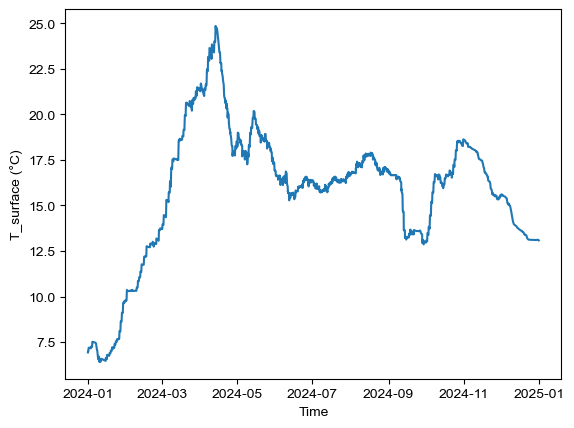

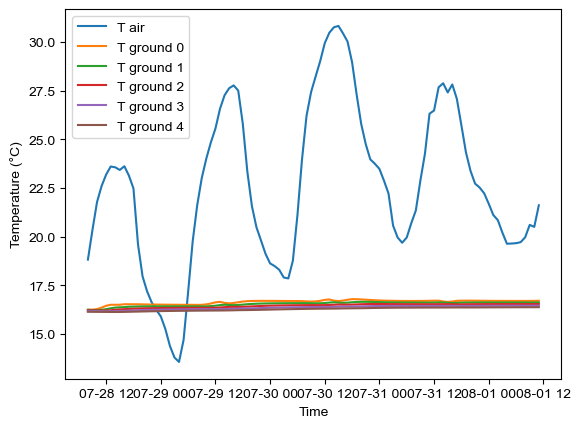

In [13]:
'A 1D heat diffusion model for the ground subsurfaces and energy balance for the ground surface is used to calculate the ground temperature and heat fluxes. '
'Nevertheless, an empirical model and Semi-Analytical Force-Restore Method functions are also available in functions_module.py'

Rn = poa_ground_updated                 # Net radiation (W/m²)
LAI = 3.0829                            # m²/m²(soil), apple/pear tree (calculated from KUL demonstrator)
Kcb_h = np.repeat(Kcb, 24)
L_ET = q_ET0_Wm2*Kcb_h                  # Latent heat flux (W/m²) --> Assuming only basal component of ET, since EB at ground surface
# Gn = 0.4*np.exp(-0.5*LAI)*Rn          # Ground heat flux (W/m²): q absorbed by the soil (empirical assumption daylight [26.FAO])  

# Tground_TG, T_subsurface, G_subsurface, Gn_calc, H_TG, B_TG = func.Tground_ForceRestore(L_ET, Tamb)            # Force-Restore Method
# Tground_empirical = func.Tground_empirical_calc(Tamb)                                                          # Empirical Method

results_Tgr = func.Tground_Gn_calc(Rn, L_ET, pressure, Cp, Tamb, RH, theta = 0.18, soil_type = 'Sandy loam')     # 1D heat diffusion model,   thermal_soil_properties() where theta = volumetric moisture content [m3/m3] (0.1 to 0.4)
T_surface           = results_Tgr["T_surface"]
T_subsurface        = results_Tgr["T_subsurface"]
G_subsurface        = results_Tgr["G_subsurface"]
Gn                  = results_Tgr["Gn"]
G_ET                = results_Tgr["G_ET"]                                                                        # heat flux (utilized in heating the soil) for ET calculation
Hcb                 = results_Tgr["Hcb"]                                                                         # Sensible heat flux (W/m²)
B                   = results_Tgr["B"]
Cv                  = results_Tgr["Cv"]
lambda_soil         = results_Tgr["lambda"]
thermal_diffusivity = results_Tgr["alpha"]


plt.figure()                            # Annual average temperature of the ground surface
plt.plot(times, T_surface)
plt.xlabel('Time')
plt.ylabel('T_surface (°C)')    
Tground_C = T_surface
# Tground_C = T_subsurface[0,:]
print(f"mean Tgr = {np.mean(Tground_C):.2f}, min Tgr = {np.min(Tground_C):.2f}, max Tgr = {np.max(Tground_C):.2f}")


low_limit = 5000
top_limit = 5100

plt.figure()                            # Plotting the temperature of the air and sub/surface layers
plt.plot(times[low_limit:top_limit], Tair[low_limit:top_limit], label='T air')
plt.plot(times[low_limit:top_limit], T_subsurface[0, low_limit:top_limit], label='T ground 0')
plt.plot(times[low_limit:top_limit], T_subsurface[1, low_limit:top_limit], label='T ground 1')
plt.plot(times[low_limit:top_limit], T_subsurface[2, low_limit:top_limit], label='T ground 2')
plt.plot(times[low_limit:top_limit], T_subsurface[3, low_limit:top_limit], label='T ground 3')
plt.plot(times[low_limit:top_limit], T_subsurface[4, low_limit:top_limit], label='T ground 4')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')   
plt.legend()

PLOT RESULTS: Ground Temperature&Fluxes and Bowen Ratio

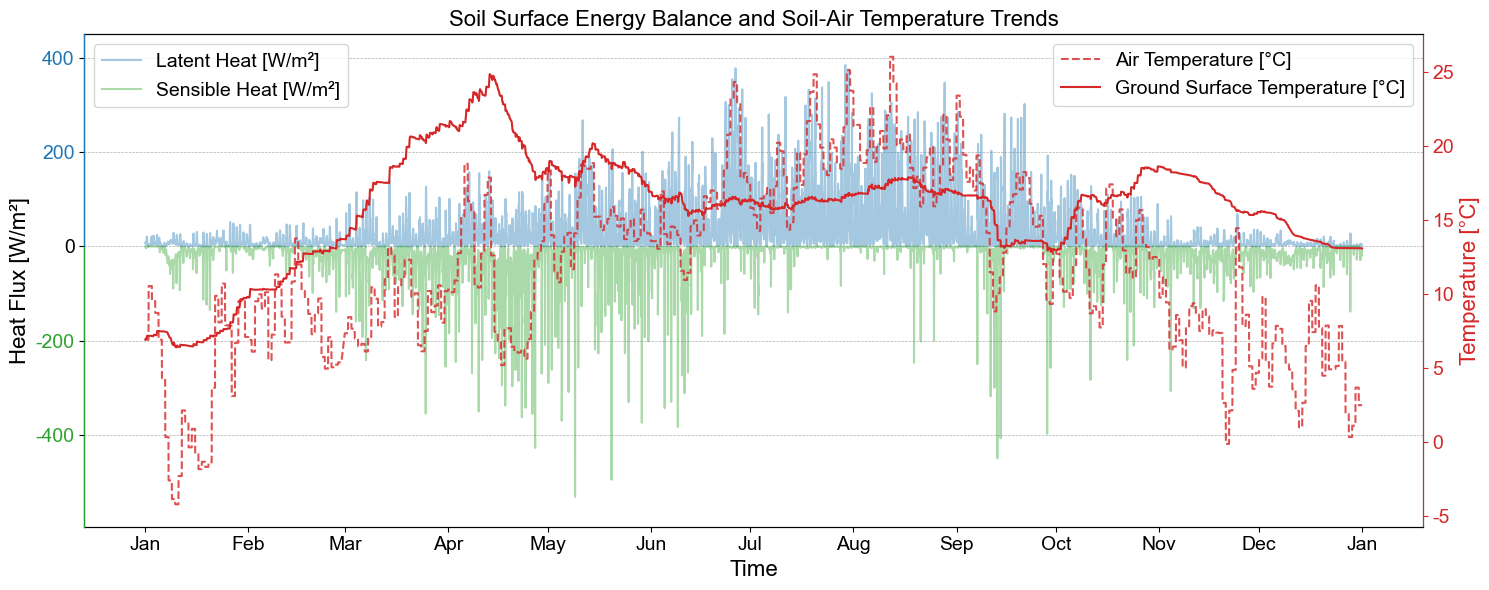

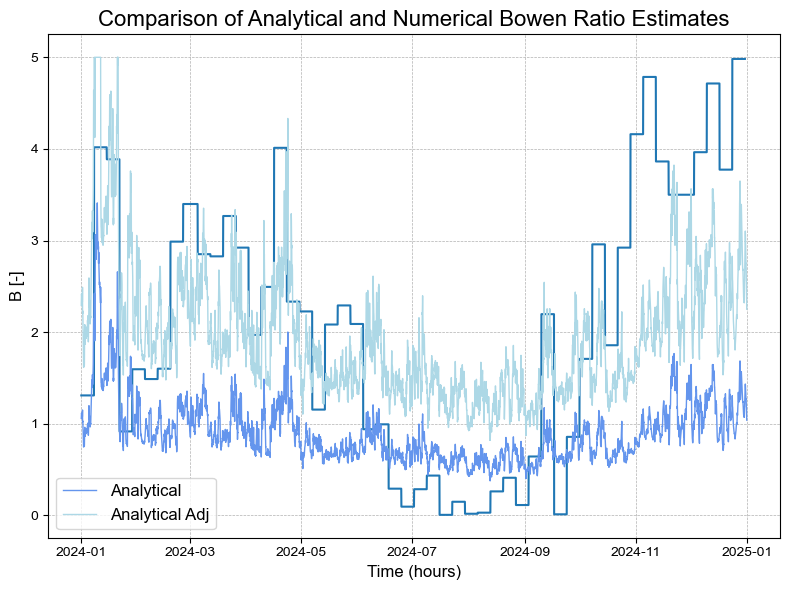

analytical: 0.9037541481443669 numerical:  2.0878995433789953


In [ ]:
B_analytical = (1.46/(RH))*((Tair_K)/273)**2 * np.exp(-19.83*(1-273/(Tair_K)))      # Analytical B value for the ground surface (W/m² K) from reference
B_analytical_adj = (3.16/(RH))*((Tair_K)/273)**2 * np.exp(-19.83*(1-273/(Tair_K)))  # Analytical adjusted B value for the ground surface (W/m² K) from reference
B_analytical_adj = np.clip(B_analytical_adj, 0, 5)
B_daily_mean = B.reshape(-1, 24).mean(axis=1)
B_daily_mean = np.repeat(B_daily_mean, 24)
hours_yr = range(0, 8760)

qET = np.ravel(np.array(q_ETc_dual_h_Wm2))
B_an = np.ravel(np.array(B_analytical))

# # April extreme scenario
# start=2250
# end=3250

# # September extreme scenario
# start=5800
# end=6800

# Hole year scenario
start=0
end=8760
Hcb[6100:6125] = np.clip(Hcb[6100:6125], a_min=None, a_max=300)
Hcb[6120:6175] = np.clip(Hcb[6120:6175], a_min=None, a_max=450)



#########################################   Plot Soil Surface Energy Balance   #######################################

fig, ax1 = plt.subplots(figsize=(15, 6))#, dpi=800)
# fig, ax1 = plt.subplots(figsize=(8, 6))#, dpi=800)

# # Plot heat flux components
# ax1.fill_between(times[start:end], Rn[start:end], label='Ground Irradiance [W/m²]', color='tab:orange', linestyle='-', alpha=0.3)

# L_ET_day = L_ET.values.reshape(-1, 2430).mean(axis=1)  # Daily mean of latent heat flux
# L_ET_smooth = np.repeat(L_ET_day, 24)  # Repeat to match the original time resolution
# Hcb_day = Hcb.values.reshape(-1, 24).mean(axis=1)  # Daily mean of sensible heat flux
# Hcb_smooth = np.repeat(Hcb_day, 24)  # Repeat to match

ax1.plot(times[start:end], L_ET[start:end], label='Latent Heat [W/m²]', color='tab:blue', alpha=0.4)
ax1.plot(times[start:end], -Hcb[start:end], label='Sensible Heat [W/m²]', color='tab:green', alpha=0.4)

ax1.set_ylabel('Heat Flux [W/m²]', fontsize=16)
ax1.set_xlabel('Time', fontsize=16)
ax1.tick_params(axis='both', labelsize=14)
ax1.legend(loc='upper left', fontsize=14)
yticks = ax1.get_yticks()
pos_ticks = [tick for tick in yticks if tick > 0]
neg_ticks = [tick for tick in yticks if tick < 0]
for tick in ax1.get_yticklabels():
    value = float(tick.get_text())
    if value > 0:
        tick.set_color('tab:blue')
    elif value < 0:
        tick.set_color('tab:green')
ax1.spines['left'].set_color('gray')
ax1.yaxis.label.set_color('black')  # Or set to one of the two if you prefer
ax1.grid(True, axis='y', which='major', linestyle='--', linewidth=0.5)
ax1.set_ylim(-595, 450)

ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# ax1.xaxis.set_major_locator(mdates.DayLocator(interval=7))
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

Tair_day = Tair.reshape(-1, 24).mean(axis=1)
Tair_smooth = np.repeat(Tair_day, 24)
# Tground_C_day = Tground_C.values.reshape(-1, 24).mean(axis=1)
# Tground_C_smooth = np.repeat(Tground_C_day, 24)

# Plot temperature on right y-axis
ax2 = ax1.twinx()
ax2.plot(times[start:end], Tair_smooth[start:end], label='Air Temperature [°C]', color='tab:red', alpha=0.8, linestyle='--')
ax2.plot(times[start:end], Tground_C[start:end], label='Ground Surface Temperature [°C]', color='tab:red')
ax2.set_ylabel('Temperature [°C]', fontsize=16)
ax2.tick_params(axis='both', labelsize=14)
ax2.tick_params(axis='y', colors='tab:red')         # Make tick labels red
ax2.spines['right'].set_color('tab:red')            # Make axis line red
ax2.yaxis.label.set_color('tab:red')                # Make axis label red
ax2.legend(loc='upper right', fontsize=14)

plt.title('Soil Surface Energy Balance and Soil-Air Temperature Trends', fontsize=16)
plt.tight_layout()

# Axis lines colors:
ymin, ymax = ax1.get_ylim()
spine_x = ax1.get_position().x0
def to_fig_coords(y_val):
    return (y_val - ymin) / (ymax - ymin) * (ax1.get_position().height) + ax1.get_position().y0
fig = plt.gcf()
fig.lines.append(plt.Line2D([spine_x, spine_x], [to_fig_coords(ymin), to_fig_coords(0)], transform=fig.transFigure, color='tab:green', linewidth=1, zorder=10))
fig.lines.append(plt.Line2D([spine_x, spine_x], [to_fig_coords(0), to_fig_coords(ymax)], transform=fig.transFigure, color='tab:blue', linewidth=1, zorder=10))
ax1.spines['left'].set_color('none')

plt.show()



#######################################   Plot Bowen Ratio   #######################################

plt.figure(figsize=(8, 6))#, dpi=1000)
# plt.plot(B[3056-5:3056+5])
# Trim B to the largest multiple of 168 (hours in a week)
n_weeks = len(B) // (24*7)
B_trimmed = B[:n_weeks * 24 * 7]
B_week = B_trimmed.reshape(-1, 24*7).mean(axis=1)  # Weekly mean
B_week_full = np.repeat(B_week, 24*7)  # Repeat to match the trimmed time resolution
# Pad with NaN to match original length if needed
if len(B_week_full) < len(B):
	B_week_full = np.concatenate([B_week_full, np.full(len(B) - len(B_week_full), np.nan)])
plt.plot(times[start:end], B_week_full[start:end])
plt.plot(times[start:end], B_analytical[start:end], label='Analytical', color='cornflowerblue', linestyle='-', linewidth=1)
plt.plot(times[start:end], B_analytical_adj[start:end], label='Analytical Adj', color='lightblue', linestyle='-', linewidth=1)
# plt.plot(times[start:end], B_daily_mean, label='Numerical', color='darkblue', linestyle='-', linewidth=1)
plt.xlabel('Time (hours)', fontsize=12)
plt.ylabel('B [-]', fontsize=12)
plt.title('Comparison of Analytical and Numerical Bowen Ratio Estimates', fontsize=16)
plt.legend(loc='best', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Add subgrid
plt.tight_layout()
plt.show()
print('analytical:', np.mean(B_analytical), 'numerical: ', np.mean(B))


MODULE TEMPERATURE SOLVER: Fluid dynamic model adapted from Fuentes (https://pvlib-python.readthedocs.io/en/v0.9.0/_modules/pvlib/temperature.html#fuentes)

In [ ]:
# RANGE of SIMMULATION: In KUL demo, for all sensor data simulation  1595:7619 (8/3/2024 11:00 - 14/11/2024 10:00) 
num_modules = 12        # number of modules in the row
low = 500               # time index for the start of the simulaiton period
top = low + 10          # time index for the end of the simulation period
# update facing: E or W (for KUL demo)!!

times_short = times[low:top]
print(times_short)
poa_global_short = poa_global_absorbed[low:top]     # [W/m2]  
Tair_K_short = Tair_K[low:top]
RH_short = RH[low:top]
pressure_short = pressure[low:top]
wind_speed_short = wind_speed[low:top]
dew_point_short = dew_point[low:top]
q_ETc_dual_h_Wm2_short = q_ETc_dual_h_Wm2[low:top]
ET_short = ETc_dual_h[low:top]
Kcb_short = Kcb_h[low:top]
Ke_short = Ke_h[low:top]
H_total = q_ETc_dual_h_Wm2*B                        # Total sensible heat released to the air from ground/crop (W/m2)
H_short = H_total[low:top]
Tground_C_short = Tground_C[low:top].reset_index(drop=True)

# ARTIFICIALLY INDUCED CASE: WIND -> 1h, 200modules, AVG  (ONLY APPLICABLE FOR SENSITIVITY ANALYSIS)
# B = 1.6 
# wind_speed_short = np.array([np.mean(wind_speed)])   
# wind_speed_short = np.array([wind_speed_induced])               
# poa_global_short = np.array([np.mean(poa_global_absorbed)])
# Tair_K_short = np.array([np.mean(Tair_K)])
# RH_short = np.array([np.mean(RH)])
# pressure_short = np.array([np.mean(pressure)])
# dew_point_short = np.array([np.mean(dew_point)])
# q_ETc_dual_h_Wm2_short = np.array([np.mean(q_ETc_dual_h_Wm2)])
# ET_short = np.array([np.mean(ETc_dual_h)])
# Kcb_short = np.array([np.mean(Kcb_h)])
# Ke_short = np.array([np.mean(Ke_h)])
# H_total = np.mean(q_ETc_dual_h_Wm2 * B)  
# H_short = np.array([H_total])
# Tground_C_short = np.array([np.mean(Tground_C)])         
# print('wind_speed:',wind_speed_short, 'G:',poa_global_short, 'Tair:', Tair_K_short-273.15, 'RH:',RH_short, 
#       'qET:', q_ETc_dual_h_Wm2_short, 'ET:', ET_short, 'Kcb:', Kcb_short, 'Ke:', Ke_short, 'H:', H_short, 'Tgr:', Tground_C_short)


def Tm_model(
    emissivity,
    tilt_angle,
    module_width,
    module_length,
    dew_point,
    num_modules,
    mc,
    poa_global=poa_global_short,
    Tair_K=Tair_K_short,
    wind_speed=wind_speed_short,
    Tground_C=Tground_C_short,
    RH=RH_short,
    pressure=pressure_short,
    times=times_short,
    ET=ET_short
):
    """
    Compute PV module temperature dynamics over time for an array of modules.

    Parameters
    ----------
    emissivity : float
        Module longwave emissivity [-].
    tilt_angle : float
        PV module tilt angle [deg].
    module_width : float
        Module width [m].
    module_length : float
        Module length [m].
    dew_point : array-like
        Dew point temperature time series [K].
    num_modules : int
        Number of PV modules considered (in flow direction).
    mc : float
        Areal heat capacity of the module [J/(m²·K)].
    poa_global : array-like
        Plane-of-array irradiance [W/m²].
    Tair_K : array-like
        Ambient air temperature [K].
    wind_speed : array-like
        Wind speed at module height [m/s].
    Tground_C : array-like
        Ground temperature [°C].
    RH : array-like
        Relative humidity [%].
    pressure : array-like
        Atmospheric pressure [Pa].
    times : array-like
        Time index aligned with inputs.
    ET : array-like
        Evapotranspiration heat flux [W/m²].

    Returns
    -------
    results_df : pd.DataFrame
        Module surface temperature per module [°C] with time index.
    Gr : np.ndarray
        Grashof number (top) time series.
    hconv_top : np.ndarray
        Total top convection coefficients [W/(m²·K)] per module and time.
    tground_array : np.ndarray
        Ground temperature [K] per time.
    h_forced_top : np.ndarray
        Forced convection (top) coefficient [W/(m²·K)] per time.
    h_free_top : np.ndarray
        Free convection (top) coefficient [W/(m²·K)] per module and time.
    hground_array : np.ndarray
        Linearized radiation coefficient to ground [W/(m²·K)] per time.
    tsky_array : np.ndarray
        Sky temperature [K] per time.
    hsky_array : np.ndarray
        Linearized radiation coefficient to sky [W/(m²·K)] per time.
    hconv_bot_array : np.ndarray
        Bottom convection coefficients [W/(m²·K)] per module and time.
    tamb_bot_array : np.ndarray
        Converged bottom air temperatures [K] per module and time.
    Tout_bot_array : np.ndarray
        Outlet temperatures below the module [K] per module and time.
    mair_bot_array : np.ndarray
        Bottom control-volume air mass flow [kg/s] per module and time.
    q_vent_array : np.ndarray
        Ventilation sensible heat flow [W] per module and time.
    RH_out_array : np.ndarray
        Outlet RH below modules [%] per module and time.
    """
    # ----------------------------- Setup ---------------------------------
    tilt_angle_rad = np.radians(tilt_angle)
    boltz = 5.669e-8                                # Stefan–Boltzmann constant [W/m²·K⁴]
    xlen = func.Dh(module_width, module_length)     # hydraulic length (kept as in original)
    cap = mc                                        # [J/(m²·K)] specific heat of the module
    pressure_kPa = pressure / 1000.0                # [kPa] atmospheric pressure
    Tground_K = Tground_C + 273.15                  # [K] Ground temperature

    n = len(wind_speed)
    Gr = np.zeros(n)
    h_forced_top = np.zeros(n)

    # Per-time arrays
    tground_array = np.zeros_like(poa_global)
    hground_array = np.zeros_like(poa_global)
    tsky_array = np.zeros_like(poa_global)
    hsky_array = np.zeros_like(poa_global)

    # Per-module, per-time arrays
    tmod_array = np.zeros((num_modules, n))
    hconv_top = np.zeros((num_modules, n))
    h_free_top = np.zeros((num_modules, n))

    hconv_bot_array = np.zeros((num_modules, n))
    tamb_bot_array = np.zeros((num_modules, n))
    RH_out_array = np.zeros((num_modules, n))
    Tout_bot_array = np.zeros((num_modules, n))
    mair_bot_array = np.zeros((num_modules, n))
    q_vent_array = np.zeros((num_modules, n))

    # Time stepping control
    timedelta_hours = np.ones(len(poa_global))  # Δt = 1 h (kept as original)
    Tair_K = np.array(Tair_K)
    daily_tamb_values = []

    # Initial conditions (kept)
    sun0 = 0.0
    tmod0 = Tground_K[0]
    tground = Tground_K[0]
    tini_day = Tair_K[0]
    avg_tamb_day = Tair_K[0]

    # -------------------------- Time loop --------------------------------
    for i, (tamb, sun, windmod, dtime) in enumerate(
        zip(Tair_K, poa_global, wind_speed, timedelta_hours)
    ):
        print(f'Hour {i}')
        day = i // 24 + 1
        countday = i - 6
        daily_tamb_values.append(tamb)

        daytime = 'day' if sun > 0 else 'night'
        if countday % 24 == 0 and i > 0:
            avg_tamb_day = np.mean(daily_tamb_values)
            daily_tamb_values = [tamb]
            tini_day = Tair_K[i]
            tmod0 = tini_day

        # Initialize per-time values
        tmod = np.full(num_modules, tmod0)

        # Ground temperature (select)
        tground = Tground_K[i]
        tground_array[i] = tground

        # Sky temperature
        tsky = func.calc_temperature_sky(float(Tair_K[i]), float(dew_point[i]), daytime)

        # Initial bottom-air guesses
        tamb_bot = np.full(num_modules, tamb)
        RH_out = np.full(num_modules, RH[i])
        Tin = tamb
        windmod = max(windmod, 0.05)

        # Control volume geometry
        CV_area_ET = module_length * module_width * np.cos(tilt_angle_rad)
        Module_area = module_width * module_length

        # ET (latent heat) terms
        H_ET = (H_short.iloc[i]) * CV_area_ET                               # [W] = ET heat flux [W/m2] * Covered ground surface area of CV [m2]
        T_rate = Kcb_short[i] / (Kcb_short[i] + Ke_short[i])                # [0-1] fraction of transpiration over evaporation: H = ET*B = ET0(Ke+Kcb)B = ET0*B*Ke + ET0*B*Kcb = H_E + H_T -> T_rate = H_T/H = Kcb/(Kcb+Ke) -> same for ET instead of H (B is simplified)
        CV_height = module_height - (crop_height / 4) * T_rate              # [m] Height of the control volume (CV): h_module - center_of_gravity_[E(z=0),T(z=h/4)_fluxes]
        CV_area_vent = CV_height * module_width * np.cos(tilt_angle_rad)    # [m2] Section of air influx

        RH_in = RH_out[0]

        for module in range(num_modules):
            for j in range(10):
                # Top BL convection (forced + free)
                Nu_forced_i, hconv_top[module, i], h_forced_top[i], h_free_top[module, i], Gr[i] = func.calc_BL_top(
                    windmod,
                    thermal_conductivity[i],
                    diffusivity[i],
                    kinematic_viscosity[i],
                    tmod[module],
                    tamb,
                    module_length,
                    module_width,
                    tilt_angle
                )

                # Bottom MB/EB iteration controls
                tol = 0.05
                iteration = 0
                max_iterations = 25

                ET_kgs = CV_area_ET * ET.iloc[i] / 3600.0  # [kg/s]
                m_air = max(density[i] * windmod * (CV_area_vent), 1e-6)
                tamb_bot_guess = tamb_bot[module] + 2 * tol
                tamb_bot_prev = tamb_bot[module]

                while abs(tamb_bot_guess - tamb_bot_prev) > tol and iteration < max_iterations:
                    iteration += 1

                    # Mass balance for RH below module
                    RH_out[module], w_out = func.RH_bot_calc(
                        m_air,
                        tamb_bot_prev - 273.15,
                        ET_kgs,
                        pressure_kPa[i],
                        RH_in
                    )

                    # Update air properties at bottom
                    air_prop = func.calc_air_properties(tamb_bot_prev, RH_in, pressure[i])
                    dynamic_viscosity_bot, density_bot, kinematic_viscosity_bot, Cp_bot, thermal_conductivity_bot, diffusivity_bot, dew_point_bot = air_prop

                    # Bottom BL convection
                    Nu_forced_bot, hconv_bot, h_forced_bot, h_free_bot, Gr_bot = func.calc_BL_bot(
                        windmod,
                        thermal_conductivity_bot,
                        diffusivity_bot,
                        kinematic_viscosity_bot,
                        tmod[module],
                        tamb_bot_prev,
                        module_length,
                        module_width,
                        tilt_angle
                    )

                    # Bottom convective heat
                    qconv_bot = hconv_bot * (tmod[module] - tamb_bot_prev) * Module_area
                    m_air = max(density_bot * windmod * CV_area_vent, 1e-6)

                    # Outlet and new guess
                    Tout = Tin + (H_ET + qconv_bot) / (m_air * Cp_bot)
                    tamb_bot_guess = (Tin + Tout) / 2

                # Store converged bottom air temperature
                tamb_bot[module] = tamb_bot_prev

                # Linearized longwave exchange (radiation losses)
                hsky = emissivity * boltz * (tmod[module] ** 2 + tsky ** 2) * (tmod[module] + tsky)
                hground = emissivity * boltz * (tmod[module] ** 2 + tground ** 2) * (tmod[module] + tground)

                # Transient ODE step solver for module temperature
                L = -((hconv_bot + hconv_top[module, i] + hsky + hground) / cap) * (dtime * 3600.0)
                ex = np.exp(L) if L > -10 else 0.0
                delta_S = sun - sun0

                tmod[module] = (
                    tmod0 * ex
                    + (
                        (1 - ex)
                        * (
                            hconv_bot * tamb_bot[module]
                            + hconv_top[module, i] * tamb
                            + hsky * tsky
                            + hground * tground
                            + sun0
                            + delta_S / L
                        )
                        + delta_S
                    )
                    / (hconv_bot + hconv_top[module, i] + hsky + hground)
                )

                tmod0 = tmod[module]
                sun0 = sun

            # Ventilation heat (negative if warming air)
            q_vent_array[module, i] = m_air * Cp_bot * (Tin - Tout)

            print(
                f"Hour {i}, Module {module}, wind:{windmod:.3f} ,Tair: {tamb:.3f}, "
                f"Tin: {Tin:.3f}, Tbot = {tamb_bot[module]:.3f}, Tout: {Tout:.3f}, "
                f"q_vent: {q_vent_array[module,i]:.3f}, H_ET: {H_ET:.3f}, q_conv,bot: {qconv_bot:.3f}"
            )

            # Pass outlet to next module inlet
            if module < num_modules - 1:
                tamb_bot[module + 1] = Tout
                Tin = Tout
                RH_in = RH_out[module]

            # Store per-module results
            hconv_bot_array[module, i] = hconv_bot
            tamb_bot_array[module, i] = tamb_bot[module]
            Tout_bot_array[module, i] = Tout
            mair_bot_array[module, i] = m_air
            tmod_array[module, i] = tmod[module]
            RH_out_array[module, i] = RH_out[module]

        # Store per-time results
        hground_array[i] = hground
        tsky_array[i] = tsky
        hsky_array[i] = hsky

    # --------------------------- Return -----------------------------------
    results_df = pd.DataFrame(
        (tmod_array - 273.15).T,
        index=times,
        columns=[f'Module_{m+1}' for m in range(num_modules)]
    )

    return (
        results_df,
        Gr,
        hconv_top,
        tground_array,
        h_forced_top,
        h_free_top,
        hground_array,
        tsky_array,
        hsky_array,
        hconv_bot_array,
        tamb_bot_array,
        Tout_bot_array,
        mair_bot_array,
        q_vent_array,
        RH_out_array,
    )

 
Tm, Gr, hconv_top, tground, h_forced_top, h_free_top, h_ground, tsky, hsky, hconv_bot, Tair_bot, Tout_bot, mair_bot, q_vent, RH_out = Tm_model(emissivity, tilt_angle, module_width, module_length, dew_point, num_modules, mc, poa_global=poa_global_short, Tair_K=Tair_K_short, wind_speed=wind_speed_short, Tground_C=Tground_C_short, times=times_short)
Tm_K = Tm + 273.15 
print('Tm: ', np.mean(Tm)) 
print('Tout_bot: ', np.mean(Tout_bot)-273.15)
print('Tair_bot: ', np.mean(Tair_bot)-273.15)
print('Tair: ', np.mean(Tair_K_short)-273.15)       

DatetimeIndex(['2024-01-21 20:00:00', '2024-01-21 21:00:00',
               '2024-01-21 22:00:00', '2024-01-21 23:00:00',
               '2024-01-22 00:00:00', '2024-01-22 01:00:00',
               '2024-01-22 02:00:00', '2024-01-22 03:00:00',
               '2024-01-22 04:00:00', '2024-01-22 05:00:00'],
              dtype='datetime64[ns]', freq=None)
Hour 0
Hour 0, Module 0, wind:4.524 ,Tair: 279.945, Tin: 279.945, Tbot = 279.945, Tout: 279.945, q_vent: 16.128, H_ET: 0.000, q_conv,bot: -16.128
Hour 0, Module 1, wind:4.524 ,Tair: 279.945, Tin: 279.945, Tbot = 279.945, Tout: 279.944, q_vent: 16.122, H_ET: 0.000, q_conv,bot: -16.122
Hour 0, Module 2, wind:4.524 ,Tair: 279.945, Tin: 279.944, Tbot = 279.944, Tout: 279.943, q_vent: 16.117, H_ET: 0.000, q_conv,bot: -16.117
Hour 0, Module 3, wind:4.524 ,Tair: 279.945, Tin: 279.943, Tbot = 279.943, Tout: 279.942, q_vent: 16.111, H_ET: 0.000, q_conv,bot: -16.111
Hour 0, Module 4, wind:4.524 ,Tair: 279.945, Tin: 279.942, Tbot = 279.942, Tout: 2

Save RESULTS

In [21]:
# SAVE data: Tm, Gr, hconv_top, tground, h_foced_top, h_free_top, h_ground, tsky, hsky, hconv_bot, Tair_bot, Tout_bot, mair_bot, q_vent, RH_out:
data = {}
data['tground'] = tground
data['h_ground'] = h_ground
data['tsky'] = tsky
data['hsky'] = hsky
data['h_forced_top'] = h_forced_top
data['Gr'] = Gr
q_ET = np.array(q_ETc_dual_h_Wm2[low:top])
data['q_ET'] = q_ET
data['B'] = np.array(B[low:top])
# data['B'] = B 
data['poa_global'] = poa_global_short  # on modules
data['poa_grass'] = np.array(poa_refgrass_updated[low:top])          # on ref grass
data['poa_ground'] = np.array(poa_ground_updated[low:top])        # on avg ground

for module in range(num_modules):
    data[f'Tm_Module_{module + 1}'] = Tm.iloc[:, module]
    data[f'Tair_bot_Module_{module + 1}'] = Tair_bot[module,:]
    data[f'Tout_bot_Module_{module + 1}'] = Tout_bot[module,:]
    data[f'mair_bot_Module_{module + 1}'] = mair_bot[module,:]
    data[f'RH_out_Module_{module + 1}'] = RH_out[module,:]
    data[f'hconv_bot_Module_{module + 1}'] = hconv_bot[module,:]
    data[f'hconv_top_Module_{module + 1}'] = hconv_top[module,:]
    data[f'h_free_top_Module_{module + 1}'] = h_free_top[module,:]

for module in range(num_modules):
    data[f'qconv_top_Module_{module + 1}'] = hconv_top[module,:] * (Tm_K.iloc[:,module] - Tair_K_short)
    data[f'qconv_bot_Module_{module + 1}'] = hconv_bot[module,:] * (Tm_K.iloc[:,module] - Tair_bot[module,:])
    data[f'q_vent_Module_{module + 1}'] = q_vent[module,:]

df = pd.DataFrame(data, index=times_short)
df.to_csv(f'./Results/Results_M{num_modules}_T{low}-{top}_{facing}_.csv', index=True, index_label='Time')